# Bank Churn
  
  <br/><br/>
 

This project aims to identify the most important factors leading to customer churn for a commercial bank.

- 11 tables
- A variety of indexes, primary and foreign key constraints
- Over 15,000 rows of data  


  
Finally, we will export the database tables in **CSV** format, which will be used to create a semantic model in **Power BI** and related dashboards in the next step.  
  
  <br/><br/>

## Importing Libraries

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import scipy.stats as stats
import warnings

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [6]:
# create a dataframe from CSV
df = pd.read_csv('../data/0-external/Churn_Banking_Modeling.csv', low_memory=False, encoding='latin-1')
df

In [7]:
# check the shape
df.shape

(377369, 43)

In [8]:
# check the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id_Cliente                           377369 non-null  int64  
 1   Flag_Richiesta_Estinzione_cc         377369 non-null  object 
 2   Imp_Valore_del_Cliente               377369 non-null  float64
 3   Flag_Apertura_Conto_Online           377369 non-null  int64  
 4   Flag_Possesso_piu_Conti              377369 non-null  int64  
 5   Eta                                  377362 non-null  float64
 6   Provincia_Domicilio                  356181 non-null  object 
 7   Provincia_Residenza                  357897 non-null  object 
 8   Anno_Apertura_primo_Conto            377369 non-null  float64
 9   Professione                          341172 non-null  object 
 10  Imp_Reddito                          157476 non-null  object 
 11  Tipologia_Cli

In [9]:
# check for duplicate rows
df.duplicated().sum()

0

Column names are in **Italian**, they will be translated into English for clarity.

In [10]:
# update column names
df.columns = ['customer_id', 'flag_closure_request', 'amt_cust_value', 'flag_online_acc_opening',
              'flag_mult_account_ownership', 'num_cust_age', 'prov_domicile', 'prov_residence',
              'num_first_account_open_year', 'cust_profession', 'cust_income', 'cust_type', 'cust_gender',
              'mifid_profile', 'amt_pricing_fee', 'amt_transfer_to_competitors', 'amt_transfer_to_non_competitors',
              'num_existing_services', 'flag_salary_deposit', 'amt_credit_card_spending', 'amt_debit_card_spending',
              'num_website_access_count', 'num_device_transactions_count', 'num_trading_activities_count',
              'num_change_services', 'flag_mortgage', 'flag_loan', 'flag_internal_tranfers', 'flag_info_closure_request',
              'flag_loyalty_program_enrol', 'flag_call_center_contact', 'flag_salary_deposit_variation',
              'num_loyalty_points', 'amt_current_liquidity', 'amt_current_managed', 'amt_current_administered',
              'amt_6m_current_liquidity', 'amt_6m_current_managed', 'amt_6m_current_administered',
              'flag_outgoing_sec_tranfer', 'flag_card_rejection', 'flag_loan_rejection', 'flag_rid_deactivation']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 43 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   customer_id                      377369 non-null  int64  
 1   flag_closure_request             377369 non-null  object 
 2   amt_cust_value                   377369 non-null  float64
 3   flag_online_acc_opening          377369 non-null  int64  
 4   flag_mult_account_ownership      377369 non-null  int64  
 5   num_cust_age                     377362 non-null  float64
 6   prov_domicile                    356181 non-null  object 
 7   prov_residence                   357897 non-null  object 
 8   num_first_account_open_year      377369 non-null  float64
 9   cust_profession                  341172 non-null  object 
 10  cust_income                      157476 non-null  object 
 11  cust_type                        377369 non-null  object 
 12  cu

In [12]:
# check for missing values
df.isnull().sum()

customer_id                             0
flag_closure_request                    0
amt_cust_value                          0
flag_online_acc_opening                 0
flag_mult_account_ownership             0
num_cust_age                            7
prov_domicile                       21188
prov_residence                      19472
num_first_account_open_year             0
cust_profession                     36197
cust_income                        219893
cust_type                               0
cust_gender                             7
mifid_profile                       49257
amt_pricing_fee                     27396
amt_transfer_to_competitors        288655
amt_transfer_to_non_competitors    176679
num_existing_services              167432
flag_salary_deposit                     0
amt_credit_card_spending           164706
amt_debit_card_spending            176004
num_website_access_count            50199
num_device_transactions_count       61605
num_trading_activities_count      

In [13]:
# drop 'customer_id' column
df.drop(columns='customer_id', inplace=True)

In [14]:
# check the shape
df.shape

(377369, 42)

In [15]:
# build a data dictionary which includes variable type and description for all features
data_dict = {'flag_closure_request':['binary-target', 'A binary flag indicating whether the customer has requested the closure of their account (1) or not (0)'],
             'amt_cust_value':['continuous', 'The total value or worth of the customer to the bank, which could be calculated based on factors such as their account balances, investments, loan amounts, etc'],
             'flag_online_acc_opening':['binary', 'A binary flag indicating whether the customer opened their account online (1) or not (0)'],
             'flag_mult_account_ownership':['binary', 'A binary flag indicating whether the customer owns multiple accounts with the bank (1) or not (0)'],
             'num_cust_age':['discrete', 'The age of the customer in years'],
             'prov_domicile':['nominal', 'The province where the customer is officially registered or has their legal residence'],
             'prov_residence':['nominal', 'The province where the customer currently resides or lives'],
             'num_first_account_open_year':['discrete', 'The year in which the customer opened their first account with the bank'],
             'cust_profession':['nominal', 'The occupation or job role of the customer'],
             'cust_income':['ordinal', 'The level of income earned by the customer, typically expressed in the currency of the country'],
             'cust_type':['ordinal', 'A categorization or classification of customers based on certain criteria or attributes'],
             'cust_gender':['binary', 'The gender of the customer (e.g., Male, Female, Other)'],
             'mifid_profile':['ordinal', 'A customer profile classification based on the Markets in Financial Instruments Directive (MiFID), which regulates investment services within the European Economic Area'],
             'amt_pricing_fee':['continuous', 'The amount of fees charged to the customer for various services, transactions, or account maintenance, expressed in the currency of the country (cc)'],
             'amt_transfer_to_competitors':['continuous', 'The amount of money transferred by the customer to other banks or financial institutions compared to their competitors'],
             'amt_transfer_to_non_competitors':['continuous', 'The amount of money transferred by the customer to other banks or financial institutions compared to non-competitors, such as internal transfers within the same bank'],
             'num_existing_services':['discrete', 'The total number of different banking services or products (e.g., accounts, loans, credit cards) that the customer currently has with the bank'],
             'flag_salary_deposit':['binary', 'A binary flag indicating whether the customer receives their salary or income deposits into their bank account (1) or not (0)'],
             'amt_credit_card_spending':['continuous', 'The amount of money spent by the customer using credit cards'],
             'amt_debit_card_spending':['continuous', 'The amount of money spent by the customer using debit cards'],
             'num_website_access_count':['discrete', 'The count or frequency of the customer access or visits to the bank website'],
             'num_device_transactions_count':['continuous', 'The count or frequency of the customer transactions using devices such as smartphones, tablets, or computers'],
             'num_trading_activities_count':['continuous', 'The count or frequency of the customer trading activities, which could include buying'],
             'num_change_services':['discrete', 'Change in the number of utilities in the last 6 months'],
             'flag_mortgage':['binary', '1 if the customer has an active mortgage, 0 otherwise'],
             'flag_loan':['binary', '1 if the customer has an active loan, 0 otherwise'],
             'flag_internal_tranfers':['binary', '1 if the customer has made transfers in the last 6 months, 0 otherwise'],
             'flag_info_closure_request':['binary', 'A binary flag indicating whether the customer has requested information regarding the closure of their account (1) or not (0)'],
             'flag_loyalty_program_enrol':['binary', 'A binary flag indicating whether the customer is enrolled in a loyalty program offered by the bank (1) or not (0)'],
             'flag_call_center_contact':['binary', 'A binary flag indicating whether the customer has had contact with the bank call center (1) or not (0)'],
             'flag_salary_deposit_variation':['binary', 'A binary flag indicating whether there has been a variation or change in the customer salary or income deposits into their bank account'],
             'num_loyalty_points':['discrete', 'The total number of loyalty program points accumulated by the customer'],
             'amt_current_liquidity':['continuous', 'The amount of liquid assets (e.g., cash, savings) currently held by the customer'],
             'amt_current_managed':['continuous', 'The amount of assets currently being managed by the bank on behalf of the customer (e.g., investments, portfolios)'],
             'amt_current_administered':['continuous', 'The amount of assets or funds currently administered by the bank on behalf of the customer (e.g., trust funds, estates)'],
             'amt_6m_current_liquidity':['continuous', 'The average amount of liquid assets held by the customer over the past 6 months'],
             'amt_6m_current_managed':['continuous', 'The average amount of assets being managed by the bank for the customer over the past 6 months'],
             'amt_6m_current_administered':['continuous', 'The average amount of assets or funds administered by the bank for the customer over the past 6 months'],
             'flag_outgoing_sec_tranfer':['binary', 'A binary flag indicating whether the customer has made outgoing transfers of securities (e.g., stocks, bonds) to other financial institutions (1) or not (0)'],
             'flag_card_rejection':['binary', 'A binary flag indicating whether the customer card transactions have been rejected by the bank (1) or not (0)'],
             'flag_loan_rejection':['binary', 'A binary flag indicating whether the customer loan applications have been rejected by the bank (1) or not (0)'],
             'flag_rid_deactivation':['binary', 'A binary flag indicating whether the customer Remote Banking ID (RID) has been deactivated (1) or not (0)']}
             

In [16]:
# split variables into continuous, discrete, ordinal, nominal and binary
continuous_vars = []
discrete_vars =   []
ordinal_vars =    []
nominal_vars =    []
binary_vars =     []

for k,v in data_dict.items():
    if v[0] == 'continuous':
        continuous_vars.append(k)
    elif v[0] == 'discrete':
        discrete_vars.append(k)
    elif v[0] == 'ordinal':
        ordinal_vars.append(k)
    elif v[0] == 'nominal':
        nominal_vars.append(k)
    elif v[0] == 'binary':
        binary_vars.append(k)

In [17]:
# define quantitative and categorical variables
quant_vars = continuous_vars + discrete_vars
categ_vars = ordinal_vars + nominal_vars + binary_vars
target = ['flag_closure_request']

In [18]:
# display variable types
print('TYPOLOGIES OF VARIABLES')
print('Continuous variables:', len(continuous_vars))
print('Discrete variables:  ', len(discrete_vars))
print('Ordinal variables:   ', len(ordinal_vars))
print('Nominal variables:   ', len(nominal_vars))
print('Binary variables:    ', len(binary_vars+target))
print()
print()
print('CONTINUOUS VARIABLES \n', continuous_vars)
print()
print('DISCRETE VARIABLES \n', discrete_vars)
print()
print('ORDINAL VARIABLES \n', ordinal_vars)
print()
print('NOMINAL VARIABLES \n', nominal_vars)
print()
print('BINARY VARIABLES \n', binary_vars+target)
print()

TYPOLOGIES OF VARIABLES
Continuous variables: 14
Discrete variables:   6
Ordinal variables:    3
Nominal variables:    3
Binary variables:     16


CONTINUOUS VARIABLES 
 ['amt_cust_value', 'amt_pricing_fee', 'amt_transfer_to_competitors', 'amt_transfer_to_non_competitors', 'amt_credit_card_spending', 'amt_debit_card_spending', 'num_device_transactions_count', 'num_trading_activities_count', 'amt_current_liquidity', 'amt_current_managed', 'amt_current_administered', 'amt_6m_current_liquidity', 'amt_6m_current_managed', 'amt_6m_current_administered']

DISCRETE VARIABLES 
 ['num_cust_age', 'num_first_account_open_year', 'num_existing_services', 'num_website_access_count', 'num_change_services', 'num_loyalty_points']

ORDINAL VARIABLES 
 ['cust_income', 'cust_type', 'mifid_profile']

NOMINAL VARIABLES 
 ['prov_domicile', 'prov_residence', 'cust_profession']

BINARY VARIABLES 
 ['flag_online_acc_opening', 'flag_mult_account_ownership', 'cust_gender', 'flag_salary_deposit', 'flag_mortgage',

## Inspecting missing values

In [19]:
# display the total number of cells
total_cells = np.product(df.shape)
total_cells

15849498

In [20]:
# display the total number of missing values
total_missing = df.isna().sum().sum()
total_missing

3291646

In [21]:
# display the percentage of data that is missing
(total_missing/total_cells) * 100

20.768140416813203

In [22]:
# count the missing values for each column, display only the ones with missing values
na_count = df.isna().sum()
na_count[na_count != 0]

num_cust_age                            7
prov_domicile                       21188
prov_residence                      19472
cust_profession                     36197
cust_income                        219893
cust_gender                             7
mifid_profile                       49257
amt_pricing_fee                     27396
amt_transfer_to_competitors        288655
amt_transfer_to_non_competitors    176679
num_existing_services              167432
amt_credit_card_spending           164706
amt_debit_card_spending            176004
num_website_access_count            50199
num_device_transactions_count       61605
num_trading_activities_count       290438
num_change_services                159014
flag_salary_deposit_variation      219893
num_loyalty_points                 250130
amt_current_liquidity                   5
amt_current_managed                266181
amt_current_administered           189735
amt_6m_current_liquidity               13
amt_6m_current_managed            

Several features have a lot of missing values (NaN).  
The way to process them will be based on their **variable types** and their **unique values**.  

In [23]:
# display features unique values
for f in na_count[na_count != 0].index:
    print(f.upper())
    print(df[f].unique())
    print()
    print()

NUM_CUST_AGE
[ 38.  45.  61.  33.  36.  48.  51.  44.  63.  32.  66.  57.  60.  40.
  49.  31.  35.  46.  42.  50.  37.  41.  39.  47.  71.  77.  54.  70.
  24.  78.  55.  58.  30.  29.  43.  56.  64.  76.  59.  65.  86.  72.
  73.  53.  81.  62.  68.  34.  74.  27.  26.  28.  79.  69.  19.  52.
  75.  67.  23.  25.  22.  87.  21.  82.  80.  83.  85.  91.  97.  84.
  90.  89.  20.  94.  88.  18.  92.  93.  16.  17.  13. 102.  99.  96.
   5.  11. 101.  14. 132. 105.  95.  98.  10.   3.   9. 100.   7.  nan
  12.   4.   6.   8.  15.]


PROV_DOMICILE
['BO' 'SA' 'VT' 'MI' 'AL' 'NO' 'BZ' 'MO' 'CT' 'RN' 'RE' 'FI' 'AV' 'PN'
 'TR' 'GE' 'VI' 'FR' 'FM' 'CR' 'RM' nan 'TO' 'PD' 'CA' 'CE' 'SR' 'BI' 'PI'
 'CO' 'CB' 'MN' 'PU' 'AR' 'PA' 'TE' 'MB' 'VA' 'SP' 'BS' 'RA' 'CI' 'PV'
 'FE' 'LU' 'PR' 'PT' 'UD' 'MC' 'FG' 'LT' 'BA' 'PO' 'TA' 'LC' 'VE' 'TP'
 'PG' 'SI' 'TN' 'GO' 'TV' 'BG' 'MS' 'CH' 'VR' 'FC' 'LI' 'GR' 'LE' 'VC'
 'OR' 'LO' 'EE' 'AQ' 'SV' 'RC' 'RG' 'SS' 'CS' 'PZ' 'AT' 'ME' 'CL' 'BR'
 'MT' 'RO' 'TS' '

[ 0. -1. nan  1.]


NUM_LOYALTY_POINTS
[   nan   325.   460. ... 38295. 36375.  7865.]


AMT_CURRENT_LIQUIDITY
[ 1634.57 11918.26  2671.95 ...  -909.87 72535.85   115.87]


AMT_CURRENT_MANAGED
[  2978.4        nan  15013.53 ...  25914.69 197987.97 338644.32]


AMT_CURRENT_ADMINISTERED
[  2980.92  34916.15 232776.62 ...  22692.68 239399.96 339296.07]


AMT_6M_CURRENT_LIQUIDITY
[ 1550.44 26122.17 16545.25 ... -2782.54 66142.32   434.01]


AMT_6M_CURRENT_MANAGED
[  2853.2        nan   5261.63 ... 139740.35 243236.45 276199.41]


AMT_6M_CURRENT_ADMINISTERED
[  2853.22  22053.82 216304.33 ... 285346.45  15208.61 276199.47]




In [24]:
# display the statistical summary of the numerical features
df.describe()

amt_cust_value  flag_online_acc_opening  flag_mult_account_ownership  \
count   377369.000000            377369.000000                377369.000000   
mean       644.662654                 0.234230                     0.071818   
std       2928.725757                 0.423517                     0.258187   
min          0.000000                 0.000000                     0.000000   
25%         46.870000                 0.000000                     0.000000   
50%         97.270000                 0.000000                     0.000000   
75%        370.320000                 0.000000                     0.000000   
max     377934.870000                 1.000000                     1.000000   

        num_cust_age  num_first_account_open_year  amt_pricing_fee  \
count  377362.000000                377369.000000    349973.000000   
mean       46.039890                  2004.805750         0.903291   
std        13.146689                     3.288509         1.825685   
min         3.000000                  1994.000000         0.000000   
25%        37.000000                  2002.000000         0.000000   
50%        43.000000                  2005.000000         0.000000   
75%        54.000000                  2008.000000         0.325000   
max       132.000000                  2010.000000         5.950000   

       amt_transfer_to_competitors  amt_transfer_to_non_competitors  \
count                 8.871400e+04                     2.006900e+05   
mean                  3.183130e+03                     3.352734e+03   
std                   1.423111e+04                     1.511987e+04   
min                   1.000000e-02                     1.000000e-02   
25%                   1.575825e+02                     3.500000e+02   
50%                   4.790000e+02                     8.058555e+02   
75%                   1.500000e+03                     2.047996e+03   
max                   1.100000e+06                     1.130700e+06   

       num_existing_services  flag_salary_deposit  amt_credit_card_spending  \
count          209937.000000        377369.000000             212663.000000   
mean                4.454517             0.417300                503.149146   
std                 3.636854             0.493114                510.779493   
min                 1.000000             0.000000                  0.010000   
25%                 2.000000             0.000000                174.649167   
50%                 3.000000             0.000000                363.346666   
75%                 6.000000             1.000000                669.673333   
max                40.000000             1.000000              27621.971666   

       amt_debit_card_spending  num_website_access_count  \
count            201365.000000             327170.000000   
mean                337.938624                  8.041092   
std                 510.884365                  7.225131   
min                   0.010000                  1.000000   
25%                 130.670000                  2.000000   
50%                 261.422500                  5.000000   
75%                 461.661666                 12.000000   
max              181522.121666                 30.000000   

       num_device_transactions_count  num_trading_activities_count  \
count                  315764.000000                  86931.000000   
mean                       10.012889                     15.143344   
std                        22.984360                     78.764646   
min                         1.000000                      1.000000   
25%                         2.000000                      1.000000   
50%                         8.000000                      2.000000   
75%                        15.000000                      6.000000   
max                     11379.000000                   6812.000000   

       num_change_services  flag_mortgage      flag_loan  \
count        218355.000000  377369.000000  377369.000000   
mean              0.

In [25]:
# save the modified dataframe as CSV
df.to_csv('../data/3-processed/df_00.csv', encoding='latin-1', index=False)

In [26]:
# load data from CSV for consistency reasons
df = pd.read_csv('../data/3-processed/df_00.csv', low_memory=False, encoding='latin-1')
df

In [27]:
# display the unique values
df['flag_closure_request'].unique()

array(['no', 'si'], dtype=object)

The **'flag_closure_request'** column has no empty values and will be binarised for analytical purposes.

In [28]:
# convert 'flag_closure_request' column into binary
df.flag_closure_request[df.flag_closure_request == 'si'] = 1
df.flag_closure_request[df.flag_closure_request == 'no'] = 0
df['flag_closure_request'] = df['flag_closure_request'].astype('int64')
df

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   flag_closure_request             377369 non-null  int64  
 1   amt_cust_value                   377369 non-null  float64
 2   flag_online_acc_opening          377369 non-null  int64  
 3   flag_mult_account_ownership      377369 non-null  int64  
 4   num_cust_age                     377362 non-null  float64
 5   prov_domicile                    356181 non-null  object 
 6   prov_residence                   357897 non-null  object 
 7   num_first_account_open_year      377369 non-null  float64
 8   cust_profession                  341172 non-null  object 
 9   cust_income                      157476 non-null  object 
 10  cust_type                        377369 non-null  object 
 11  cust_gender                      377362 non-null  object 
 12  mi

In [30]:
# display the unique values
df['flag_online_acc_opening'].unique()

array([0, 1], dtype=int64)

In [31]:
# display the unique values
df['num_cust_age'].unique()

array([ 38.,  45.,  61.,  33.,  36.,  48.,  51.,  44.,  63.,  32.,  66.,
        57.,  60.,  40.,  49.,  31.,  35.,  46.,  42.,  50.,  37.,  41.,
        39.,  47.,  71.,  77.,  54.,  70.,  24.,  78.,  55.,  58.,  30.,
        29.,  43.,  56.,  64.,  76.,  59.,  65.,  86.,  72.,  73.,  53.,
        81.,  62.,  68.,  34.,  74.,  27.,  26.,  28.,  79.,  69.,  19.,
        52.,  75.,  67.,  23.,  25.,  22.,  87.,  21.,  82.,  80.,  83.,
        85.,  91.,  97.,  84.,  90.,  89.,  20.,  94.,  88.,  18.,  92.,
        93.,  16.,  17.,  13., 102.,  99.,  96.,   5.,  11., 101.,  14.,
       132., 105.,  95.,  98.,  10.,   3.,   9., 100.,   7.,  nan,  12.,
         4.,   6.,   8.,  15.])

In [32]:
# display the unique values
df['prov_domicile'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'CB', 'MN', 'PU',
       'AR', 'PA', 'TE', 'MB', 'VA', 'SP', 'BS', 'RA', 'CI', 'PV', 'FE',
       'LU', 'PR', 'PT', 'UD', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA', 'LC',
       'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'TV', 'BG', 'MS', 'CH', 'VR',
       'FC', 'LI', 'GR', 'LE', 'VC', 'OR', 'LO', 'EE', 'AQ', 'SV', 'RC',
       'RG', 'SS', 'CS', 'PZ', 'AT', 'ME', 'CL', 'BR', 'MT', 'RO', 'TS',
       'PC', 'CN', 'AG', 'RI', 'PE', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'BN', 'VB', 'IS', 'AO', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO', '8N', 'BE'], dtype=object)

In [33]:
# display the unique values
df['prov_residence'].unique()

array(['BO', 'SA', 'VT', 'MI', 'AL', 'NO', 'BZ', 'MO', 'CT', 'RN', 'RE',
       'FI', 'AV', 'PN', 'TR', 'GE', 'VI', 'FR', 'FM', 'CR', 'RM', nan,
       'TO', 'PD', 'CA', 'CE', 'SR', 'BI', 'PI', 'CO', 'FC', 'CB', 'MN',
       'PU', 'BN', 'AR', 'PA', 'TE', 'MB', 'VA', 'BS', 'RA', 'CI', 'PV',
       'FE', 'LU', 'PR', 'PT', 'TS', 'MC', 'FG', 'LT', 'BA', 'PO', 'TA',
       'LC', 'GR', 'VE', 'TP', 'PG', 'SI', 'TN', 'GO', 'UD', 'TV', 'BG',
       'MS', 'CH', 'VR', 'LI', 'LE', 'VC', 'SP', 'SS', 'OR', 'LO', 'AQ',
       'CN', 'RC', 'RG', 'RO', 'CS', 'PZ', 'AT', 'ME', 'CL', 'SV', 'BR',
       'MT', 'PC', 'PE', 'AG', 'RI', 'CZ', 'IM', 'AP', 'AN', 'BT', 'VS',
       'NU', 'BL', 'OT', 'OG', 'VB', 'EE', 'AO', 'IS', 'SO', 'EN', 'KR',
       'VV', 'PS', 'FO'], dtype=object)

In [34]:
# display the unique values
df['num_first_account_open_year'].unique()

array([2004., 2000., 2005., 2010., 2001., 2008., 2002., 2007., 2003.,
       2006., 2009., 1999., 1994., 1995., 1998., 1996., 1997.])

In [35]:
# convert 'num_first_account_year' column into integer
df['num_first_account_open_year'] = df['num_first_account_open_year'].astype('int64')
df['num_first_account_open_year'].unique()

array([2004, 2000, 2005, 2010, 2001, 2008, 2002, 2007, 2003, 2006, 2009,
       1999, 1994, 1995, 1998, 1996, 1997], dtype=int64)

In [36]:
# display the unique values
df['cust_profession'].unique()

array(['Impiegato', 'Altro/Nessuno', 'Quadro', 'Operaio', nan,
       'Ufficiale/Sottufficiale',
       'Libero professionista/Titolare di impresa', 'Dirigente',
       'Commercialista', 'Rappresentante/Agente', 'Ingegnere/Architetto',
       'Avvocato', 'Medico/Farmacista', 'Autotrasportatore',
       'Docente/Insegnante', 'Commesso/Ausiliario',
       'Ufficiale/Sottoufficiale',
       'Libero professionista/Titolare impresa', 'Notaio'], dtype=object)

In [37]:
# display the unique values
df['cust_income'].unique()

array(['Medio (tra 1500 e 1800)', 'Alto (tra 1800 e 2500)',
       'Basso (tra 1200 e 1500)', nan, 'Altissimo (>2500)',
       'Bassissimo (<1200)'], dtype=object)

In [38]:
# display the unique values
df['cust_type'].unique()

array(['Investor', 'Trader', 'ActiveTrader', 'Banker', 'Sleeper'],
      dtype=object)

In [39]:
# display the unique values
df['cust_gender'].unique()

array(['M', 'F', nan], dtype=object)

In [40]:
# display the unique values
df['cust_gender'].value_counts()

M    265032
F    112330
Name: cust_gender, dtype: int64

In [41]:
# display the unique values
df['mifid_profile'].unique()

array(['PRUDENTE', 'BILANCIATO', 'DINAMICO', nan, 'ND', 'CAUTO'],
      dtype=object)

In [42]:
# display the unique values
df['num_existing_services'].unique()

array([ 3.,  7.,  9., nan,  4.,  5., 14.,  1.,  2.,  6., 39.,  8., 13.,
       12., 15., 10., 11., 16., 19., 18., 20., 17., 27., 23., 21., 24.,
       22., 28., 25., 31., 26., 29., 30., 32., 38., 35., 40., 33.])

In [43]:
# display the unique values
df['num_website_access_count'].unique()

array([14., 25., 18.,  4., 16., nan, 12.,  1.,  5.,  6.,  3., 21., 19.,
        7.,  2., 23., 22.,  8., 24., 15., 10.,  9., 17., 20., 13., 11.,
       26., 27., 29., 28., 30.])

In [44]:
# display the unique values
df['num_device_transactions_count'].unique()

array([5.8000e+01, 8.0000e+00, 1.3000e+01, 4.0000e+00, 1.0000e+00,
              nan, 2.1000e+01, 1.0000e+01, 3.0000e+00, 7.0000e+00,
       1.5000e+01, 1.8000e+01, 1.1000e+01, 6.0000e+00, 1.2000e+01,
       9.0000e+00, 2.0000e+00, 3.4000e+01, 2.4000e+01, 5.0000e+00,
       2.6000e+01, 1.4000e+01, 2.0000e+01, 2.2000e+01, 1.6000e+01,
       1.7000e+01, 1.9000e+01, 2.5000e+01, 2.3000e+01, 3.3000e+01,
       2.8000e+01, 4.5000e+01, 3.6000e+01, 3.0000e+01, 4.0000e+01,
       3.2000e+01, 2.9000e+01, 3.7000e+01, 5.5000e+01, 3.5000e+01,
       3.1000e+01, 4.8000e+01, 2.7000e+01, 4.4000e+01, 4.2000e+01,
       5.0000e+01, 6.3000e+01, 4.7000e+01, 3.9000e+01, 4.1000e+01,
       3.8000e+01, 4.3000e+01, 5.1000e+01, 5.4000e+01, 7.1000e+01,
       5.6000e+01, 4.9000e+01, 4.6000e+01, 5.2000e+01, 5.3000e+01,
       6.1000e+01, 5.7000e+01, 6.0000e+01, 9.0000e+01, 1.1500e+02,
       1.0400e+02, 9.4000e+01, 6.5000e+01, 6.2000e+01, 7.4000e+01,
       6.4000e+01, 5.9000e+01, 6.8000e+01, 1.3300e+02, 6.6000e

In [45]:
# display the unique values
df['num_trading_activities_count'].unique()

array([      nan, 2.000e+00, 7.000e+00, 7.200e+01, 1.000e+00, 8.000e+00,
       4.000e+00, 2.400e+01, 1.570e+02, 6.000e+00, 3.000e+00, 1.070e+02,
       1.000e+01, 3.700e+01, 7.300e+01, 9.000e+00, 1.300e+01, 5.000e+00,
       3.800e+01, 2.000e+01, 2.800e+01, 1.400e+01, 2.600e+01, 1.900e+01,
       3.000e+01, 1.700e+01, 3.490e+02, 3.500e+01, 4.070e+02, 5.810e+02,
       9.600e+01, 1.600e+01, 6.100e+01, 1.060e+02, 1.500e+01, 3.100e+01,
       3.200e+01, 1.200e+01, 6.700e+01, 2.100e+01, 2.200e+01, 1.100e+01,
       9.300e+01, 3.900e+01, 1.150e+02, 1.480e+02, 6.600e+02, 1.360e+02,
       1.800e+01, 6.600e+01, 9.700e+01, 4.300e+01, 4.600e+01, 4.100e+01,
       1.830e+02, 2.300e+01, 3.600e+01, 3.480e+02, 5.700e+01, 2.500e+01,
       2.610e+02, 9.500e+01, 3.520e+02, 5.400e+01, 8.300e+01, 8.800e+01,
       7.900e+01, 2.270e+02, 7.600e+01, 2.840e+02, 1.720e+02, 3.400e+01,
       2.900e+01, 6.500e+01, 2.700e+01, 1.260e+02, 1.730e+02, 2.070e+02,
       4.000e+01, 9.800e+01, 1.530e+02, 4.010e+02, 

In [46]:
# display the unique values
df['num_change_services'].unique()

array([  0.,   1.,  -1.,  nan,   2.,  -4., -23.,  -8.,  -5.,  -2.,  -7.,
        -6.,  -3.,   3., -11.,   4.,   5.,  15.,   7.,   6.,   8.,  10.,
        11.,  12., -14., -10.,   9.,  -9.,  16., -12.,  14., -13.,  22.,
        18., -16., -15.,  13.,  17.,  19., -17.,  21.,  20., -26.,  25.])

In [47]:
# check the value percentages for the 'prov_domicile' column
df.prov_domicile.value_counts(normalize=True)

RM    0.147911
MI    0.088186
TO    0.056567
BS    0.029061
GE    0.023951
BG    0.021972
BO    0.021439
CT    0.019911
FI    0.019479
PA    0.019041
SA    0.018218
MB    0.017674
VA    0.014568
CE    0.014394
PD    0.014114
VR    0.013367
LT    0.012870
MO    0.011935
FR    0.011651
PV    0.011629
PG    0.011222
RE    0.010885
TV    0.010792
VE    0.010514
CA    0.010408
BA    0.010349
AN    0.009810
VI    0.009711
LE    0.009557
SR    0.009338
PR    0.008521
CO    0.008490
ME    0.007881
UD    0.007679
RN    0.007566
SP    0.007238
TA    0.007199
PI    0.007030
PU    0.006772
SV    0.006721
FE    0.006561
LU    0.006533
RC    0.006354
NO    0.006320
PO    0.006233
CH    0.006171
AV    0.006118
FC    0.005893
AL    0.005778
LI    0.005747
RA    0.005741
TS    0.005739
AR    0.005455
MC    0.005351
TR    0.005329
PT    0.005303
MN    0.005003
PN    0.004846
CN    0.004787
CR    0.004632
TN    0.004596
PE    0.004506
LC    0.004338
PC    0.004273
MS    0.004085
RG    0.004043
CS    0.00

In [48]:
# check the value percentages for the 'prov_residence' column
df.prov_residence.value_counts(normalize=True)

RM    0.140691
MI    0.081266
TO    0.055709
BS    0.029042
GE    0.024074
BG    0.021883
CT    0.020414
BO    0.020349
PA    0.019620
SA    0.019307
FI    0.018813
MB    0.017064
CE    0.014596
VA    0.014392
PD    0.014188
VR    0.013378
LT    0.013347
FR    0.012006
MO    0.011713
PG    0.011593
PV    0.011319
BA    0.010992
VE    0.010897
TV    0.010877
RE    0.010858
CA    0.010735
LE    0.010349
SR    0.009807
AN    0.009763
VI    0.009698
CO    0.008536
ME    0.008480
PR    0.008477
UD    0.007868
TA    0.007784
RN    0.007477
SP    0.007245
RC    0.006896
SV    0.006876
PU    0.006854
PI    0.006784
FE    0.006697
AV    0.006605
LU    0.006591
CH    0.006524
NO    0.006292
PO    0.006108
AL    0.005960
FC    0.005896
LI    0.005887
TS    0.005801
RA    0.005778
AR    0.005546
MC    0.005460
TR    0.005401
PT    0.005284
MN    0.005122
PN    0.005013
CN    0.004817
TN    0.004797
CS    0.004691
PE    0.004688
CR    0.004415
LC    0.004406
RG    0.004283
PC    0.004241
MS    0.00

In [49]:
# perform ordinal encoding - categorical variables where values are not correctly designated
# note: where the customer does not have the feature ('NA') it will be assigned a value of 0

# map 'cust_income' to encoded values
df['cust_income'] = df['cust_income'].map({'Altissimo (>2500)'       : 5, 
                                           'Alto (tra 1800 e 2500)'  : 4, 
                                           'Medio (tra 1500 e 1800)' : 3, 
                                           'Basso (tra 1200 e 1500)' : 2, 
                                           'Bassissimo (<1200)'      : 1, 
                                           np.nan                    : 0})


# map 'cust_type' to encoded values
df['cust_type'] = df['cust_type'].map({'Banker'       : 4, 
                                       'Investor'     : 3, 
                                       'ActiveTrader' : 2, 
                                       'Trader'       : 1, 
                                       'Sleeper'      : 0})


# map 'mifid_profile' to encoded values
df['mifid_profile'] = df['mifid_profile'].map({'DINAMICO'   : 5, 
                                               'BILANCIATO' : 4, 
                                               'PRUDENTE'   : 3, 
                                               'CAUTO'      : 2, 
                                               'ND'         : 1, 
                                               np.nan       : 0})

In [50]:
# save the modified dataframe as CSV
df.to_csv('../data/3-processed/df_01.csv', encoding='latin-1', index=False)

In [51]:
# load data from CSV for consistency reasons
df = pd.read_csv('../data/3-processed/df_01.csv', low_memory=False, encoding='latin-1')

In [52]:
province_counts = df['prov_residence'].value_counts().reset_index()
province_counts.columns = ['prov_residence', 'customer_count']

## Exploratory Data Analysis

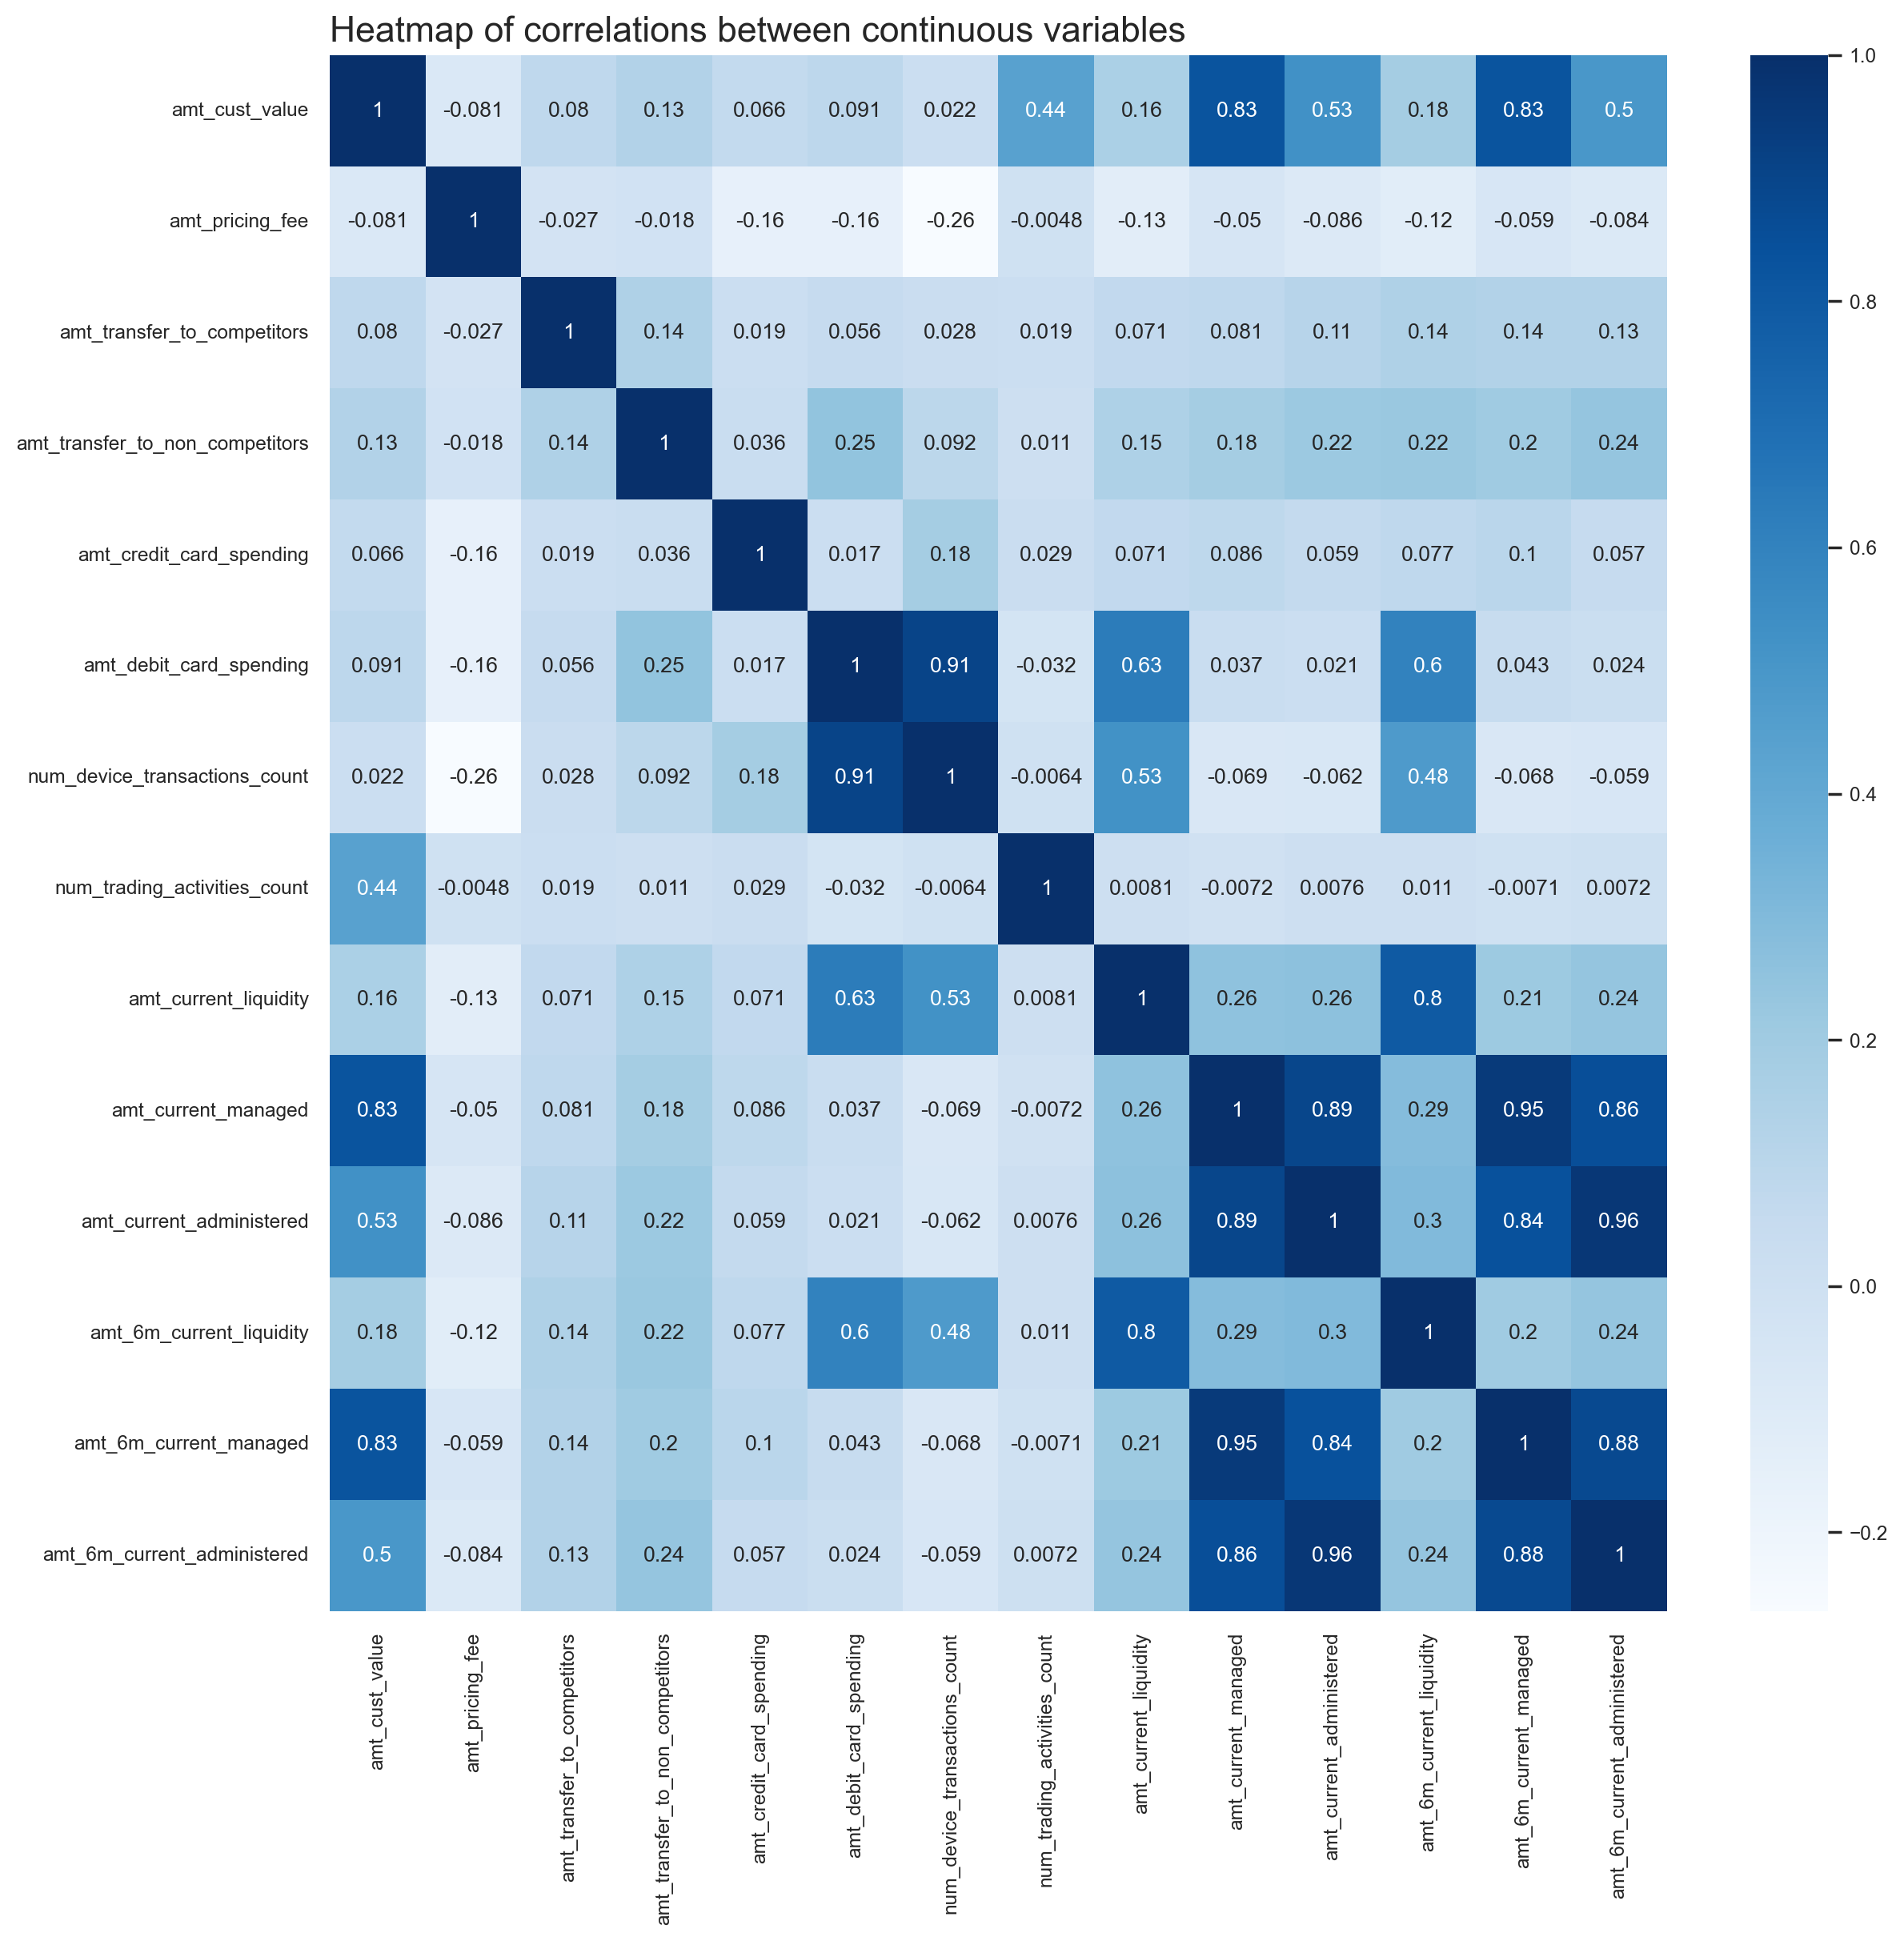

In [53]:
# create heatmap to explore correlations between continuous variables
plt.figure(figsize=(12, 12))
plt.title('Heatmap of correlations between continuous variables', loc='left', fontsize = 16)
sns.heatmap(df[continuous_vars].corr(), cmap='Blues', annot=True)
plt.show()

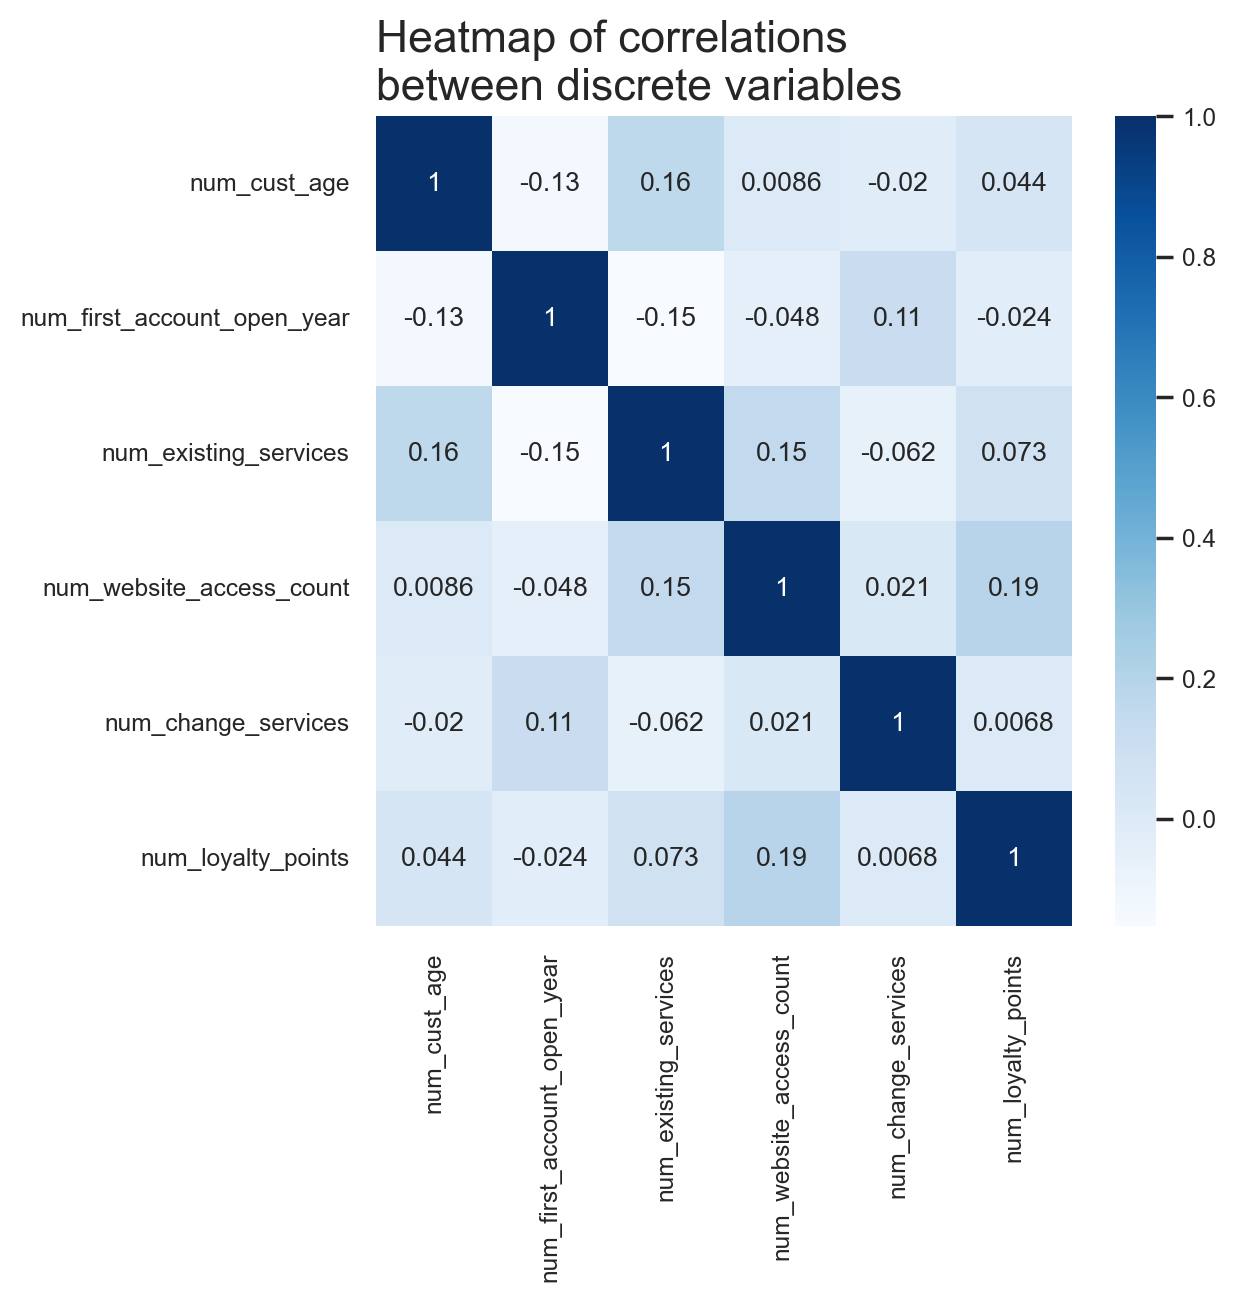

In [54]:
# create heatmap to explore correlations between discrete variables
plt.figure(figsize=(5, 5))
plt.title('Heatmap of correlations \nbetween discrete variables', loc='left', fontsize = 16)
sns.heatmap(df[discrete_vars].corr(), cmap='Blues', annot=True)
plt.show()

In [55]:
# create a standardised dataframe for quantitative variables
scaler = StandardScaler()
quant_std = scaler.fit_transform(df[quant_vars])

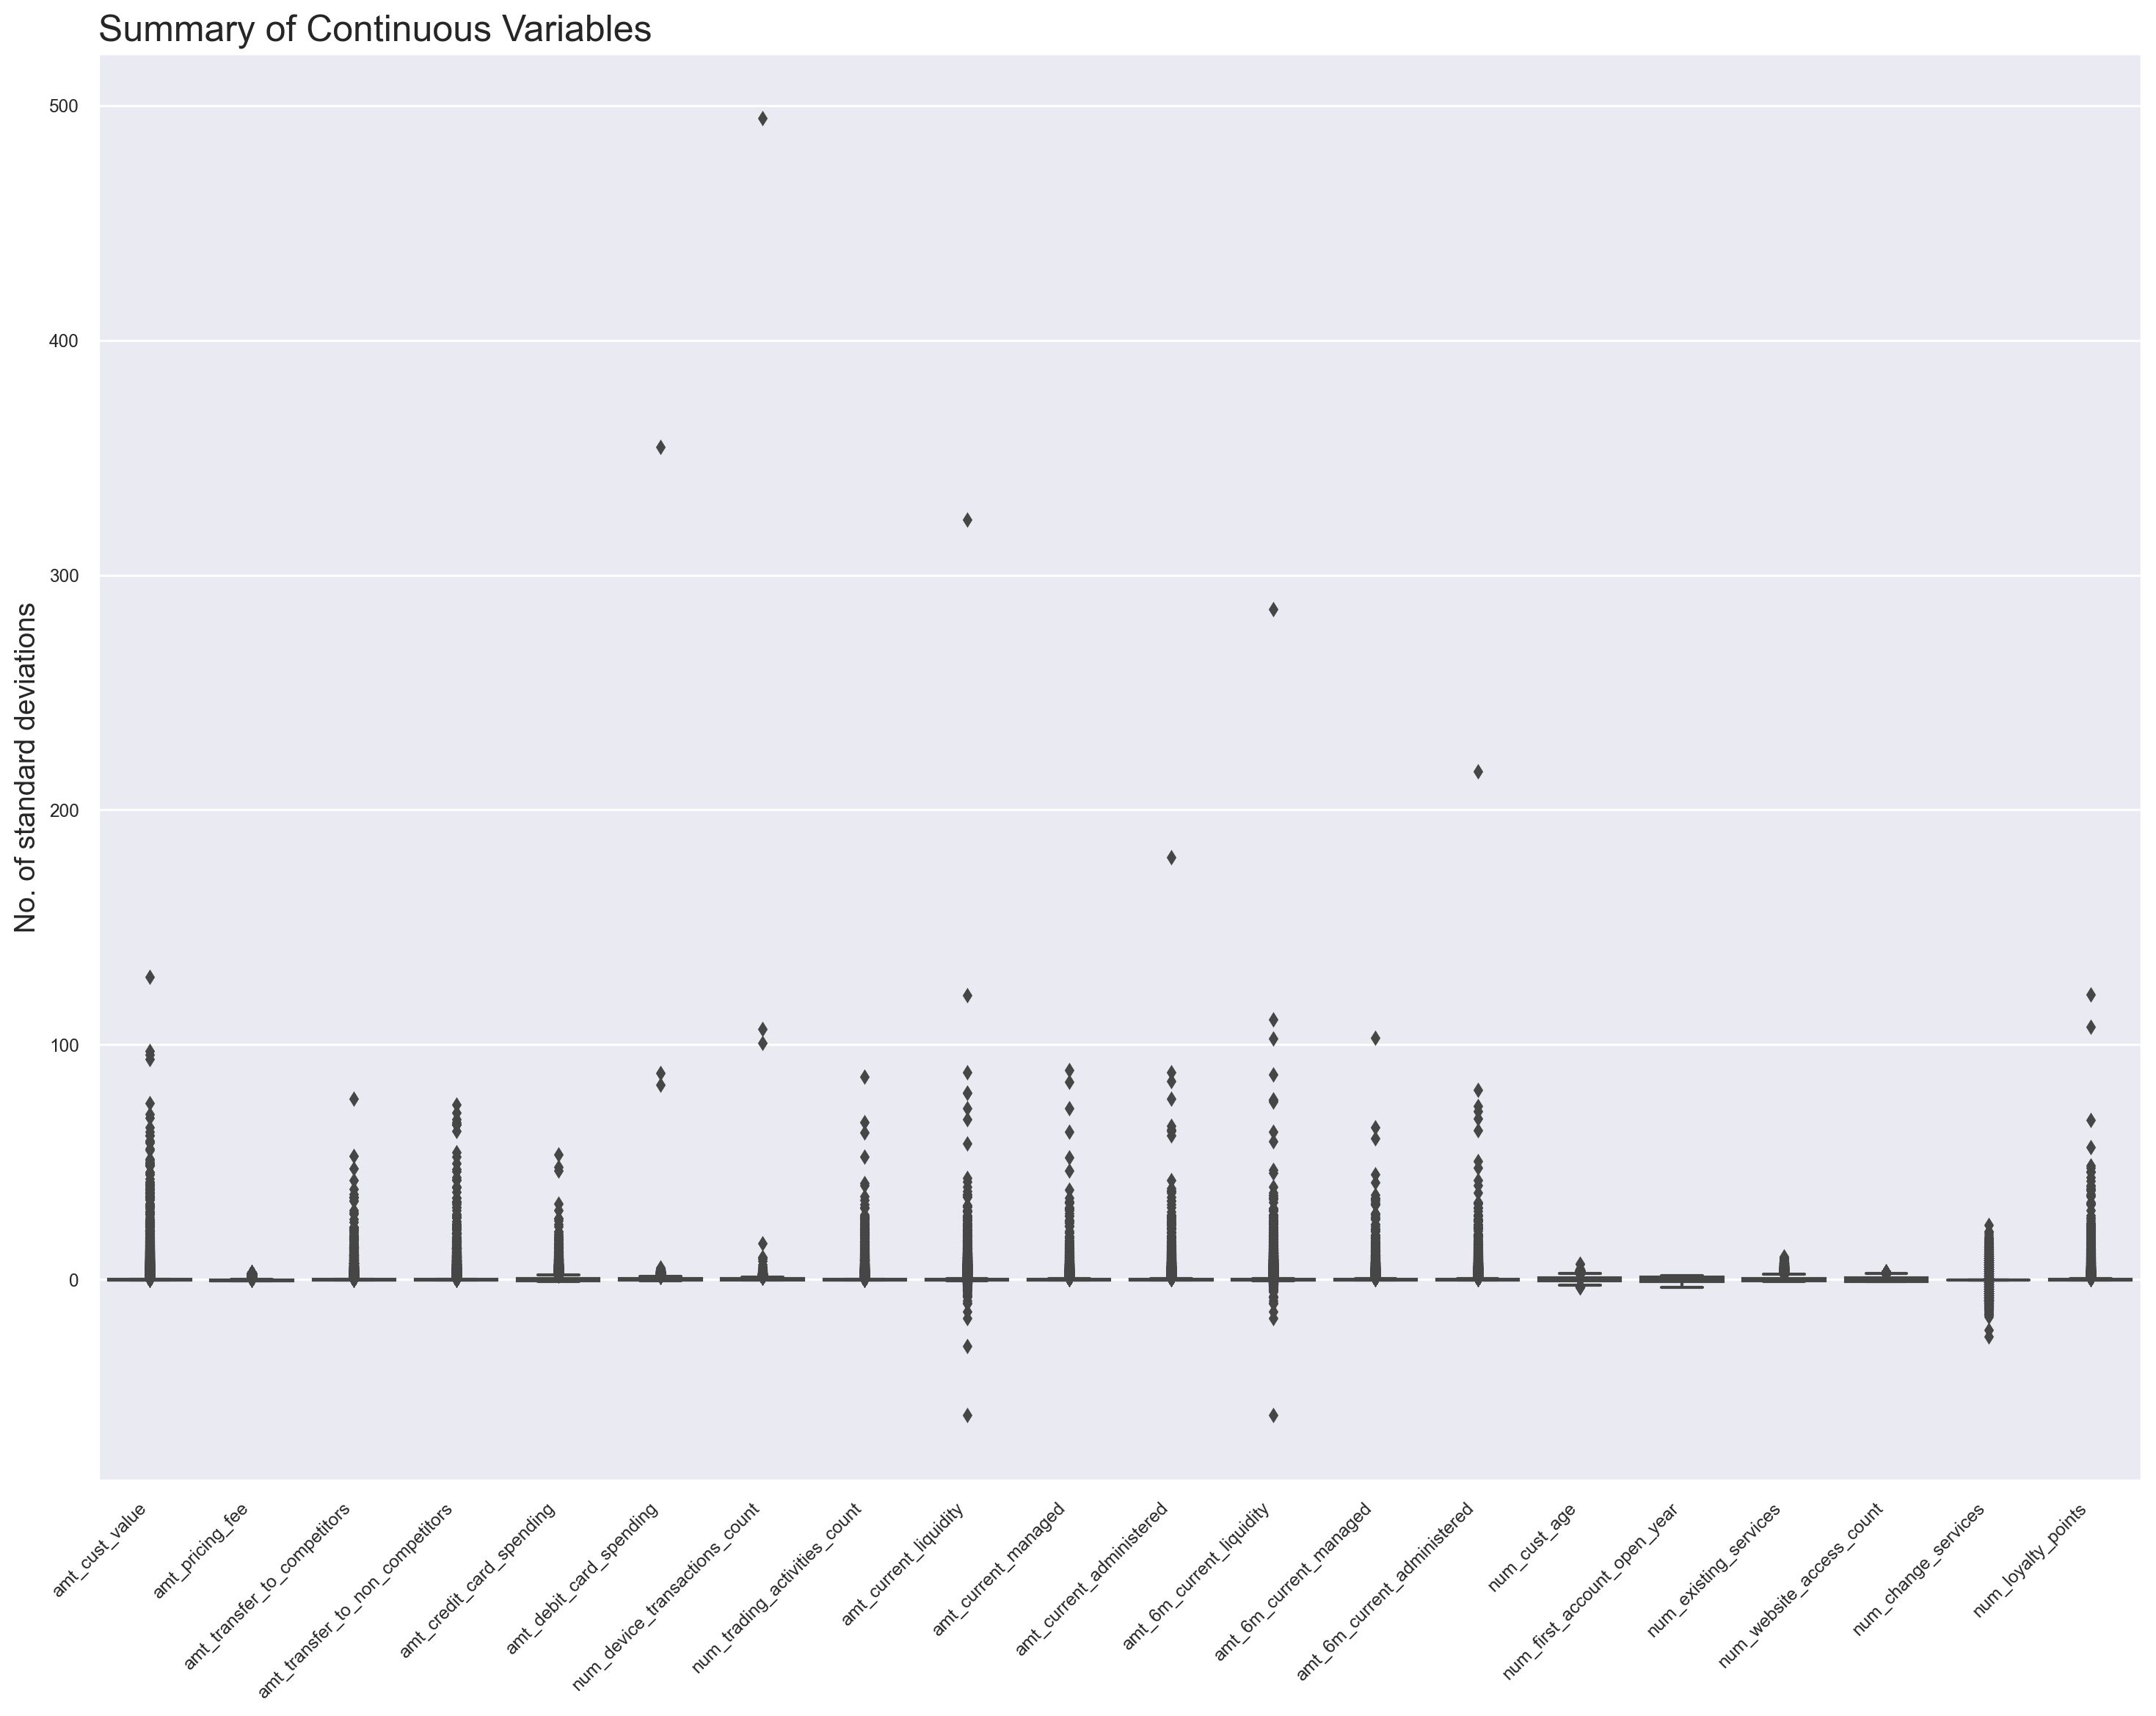

In [56]:
# plot the summary of standardised continuous variables to check for outliers
fig, ax = plt.subplots(figsize = (16,12))

sns.boxplot(data = quant_std, fliersize = 4)
ax.set_title('Summary of Continuous Variables', loc='left', fontsize=18)
ax.set_xticks([x for x in range(len(quant_vars))], labels = quant_vars, rotation = 45, horizontalalignment = 'right')
ax.set_ylabel('No. of standard deviations', fontsize = 14)

plt.show()

In [57]:
# box plot for every variable (age, spending...)

In [58]:
# display the average customer value for remaining and closing accounts
cust_value = df.groupby('flag_closure_request')[['amt_cust_value']].mean()
cust_value

amt_cust_value
flag_closure_request                
0                         646.090098
1                         374.444534

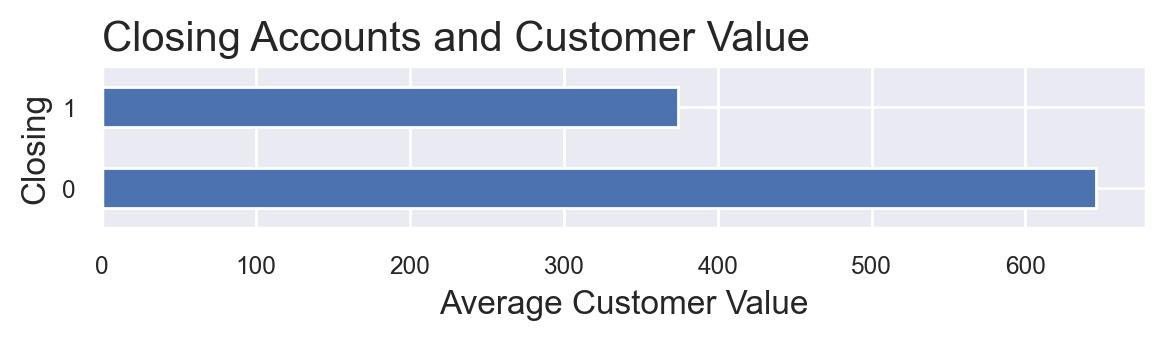

In [59]:
# create a horizontal bar plot showing the average customer value for remaining and closing accounts
cust_value.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Customer Value', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Customer Value', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [60]:
# display the average customer age for remaining and closing accounts
cust_age = df.groupby('flag_closure_request')[['num_cust_age']].mean()
cust_age

num_cust_age
flag_closure_request              
0                        46.023723
1                        49.100353

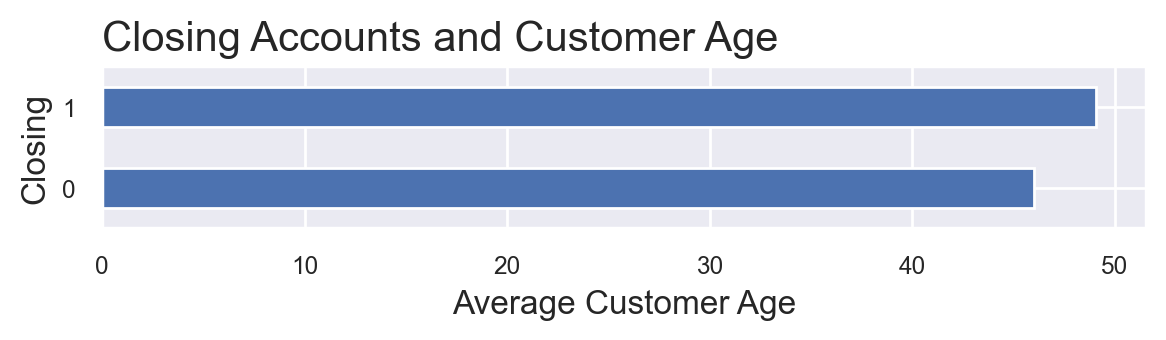

In [61]:
# create a horizontal bar plot showing the average customer age for remaining and closing accounts
cust_age.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Customer Age', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Customer Age', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [62]:
# statistical significance?
# p-value?


In [63]:
# display the average customer age for remaining and closing accounts
#cust_profession = df.groupby('flag_closure_request')[['cust_profession']].mode()
#cust_profession

In [64]:
# display the average transfers to competitors value for remaining and closing accounts
transf_comp = df.groupby('flag_closure_request')[['amt_transfer_to_competitors']].mean()
transf_comp

amt_transfer_to_competitors
flag_closure_request                             
0                                     3167.316225
1                                     8402.074078

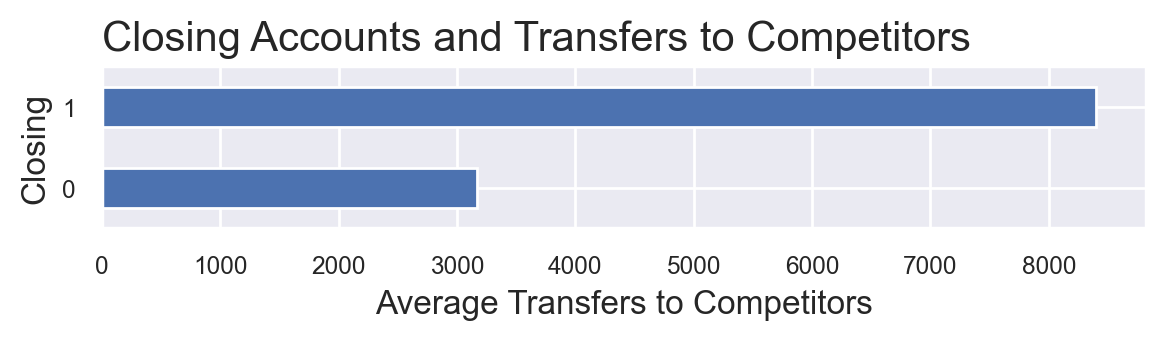

In [65]:
# create a horizontal bar plot showing the average transfers to competitors value for remaining and closing accounts
transf_comp.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Transfers to Competitors', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Transfers to Competitors', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [66]:
# display the average transfers to non competitors value for remaining and closing accounts
transf_non_comp = df.groupby('flag_closure_request')[['amt_transfer_to_non_competitors']].mean()
transf_non_comp

amt_transfer_to_non_competitors
flag_closure_request                                 
0                                         3308.909997
1                                        15855.200363

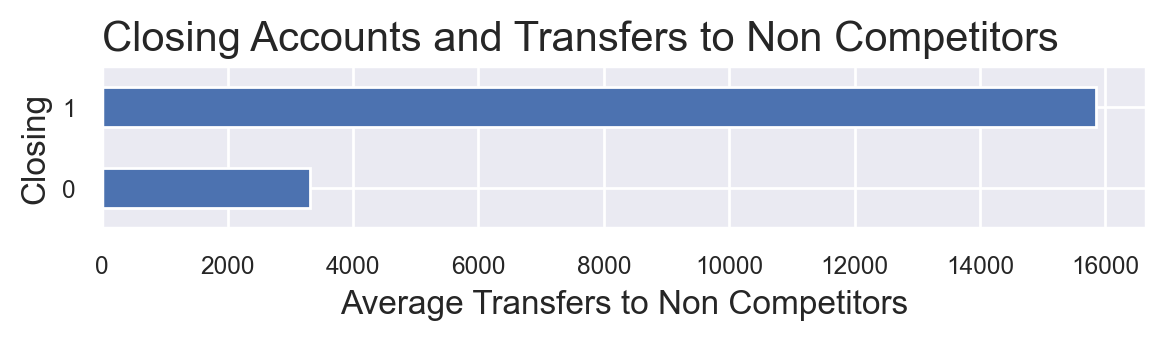

In [67]:
# create a horizontal bar plot showing the average transfers to non competitors value for remaining and closing accounts
transf_non_comp.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Transfers to Non Competitors', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Transfers to Non Competitors', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [68]:
# display the average existing services value for remaining and closing accounts
exist_serv = df.groupby('flag_closure_request')[['num_existing_services']].mean()
exist_serv

num_existing_services
flag_closure_request                       
0                                  4.458113
1                                  3.316188

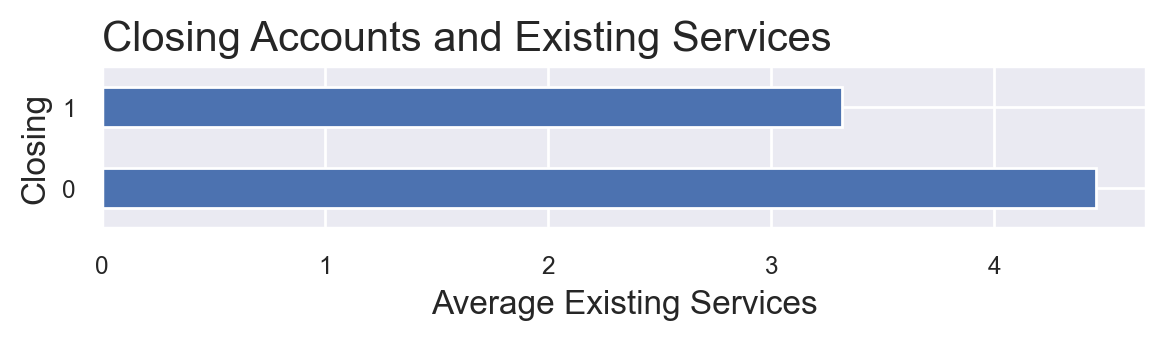

In [69]:
# create a horizontal bar plot showing the average existing services value for remaining and closing accounts
exist_serv.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Existing Services', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Existing Services', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [70]:
# display the average credit card spending for remaining and closing accounts
credit_card_spe = df.groupby('flag_closure_request')[['amt_credit_card_spending']].mean()
credit_card_spe

amt_credit_card_spending
flag_closure_request                          
0                                   503.463134
1                                   347.449737

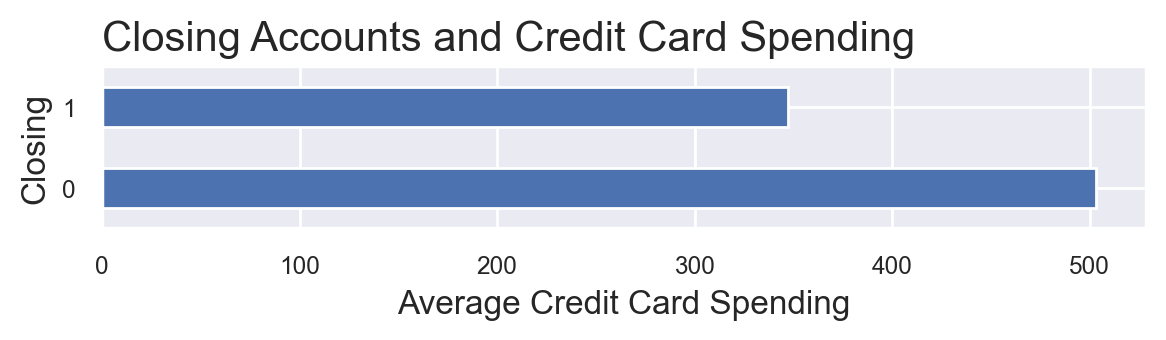

In [71]:
# create a horizontal bar plot showing the average credit card spending value for remaining and closing accounts
credit_card_spe.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Credit Card Spending', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Credit Card Spending', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [72]:
# display the average debit card spending for remaining and closing accounts
debit_card_spe = df.groupby('flag_closure_request')[['amt_debit_card_spending']].mean()
debit_card_spe

amt_debit_card_spending
flag_closure_request                         
0                                  338.008865
1                                  307.394077

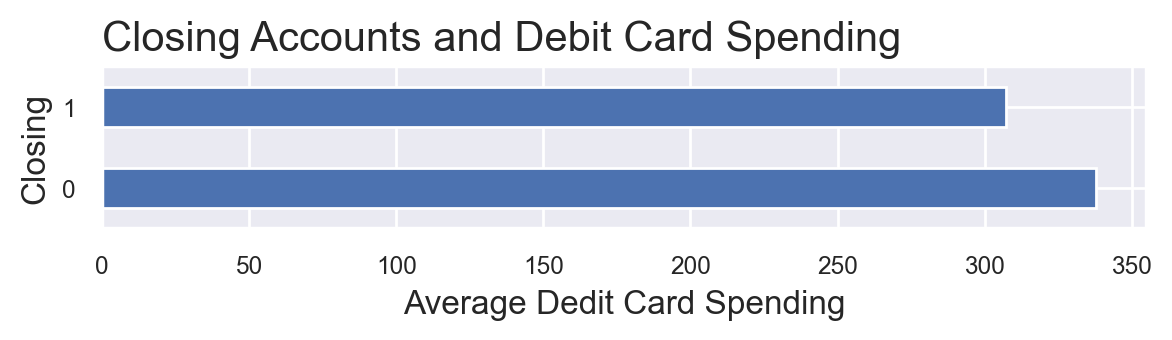

In [73]:
# create a horizontal bar plot showing the average debit card spending value for remaining and closing accounts
debit_card_spe.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Debit Card Spending', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Dedit Card Spending', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [74]:
# display the average website access count for remaining and closing accounts
website_access = df.groupby('flag_closure_request')[['num_website_access_count']].mean()
website_access

num_website_access_count
flag_closure_request                          
0                                     8.053051
1                                     5.201166

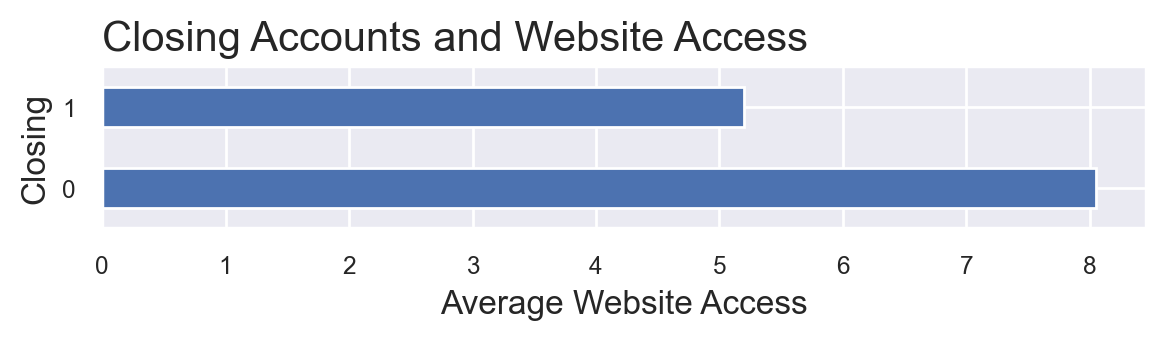

In [75]:
# create a horizontal bar plot showing the average website access count for remaining and closing accounts
website_access.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Website Access', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Website Access', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [76]:
# display the average device transactions count for remaining and closing accounts
device_transact = df.groupby('flag_closure_request')[['num_device_transactions_count']].mean()
device_transact

num_device_transactions_count
flag_closure_request                               
0                                         10.036226
1                                          4.589800

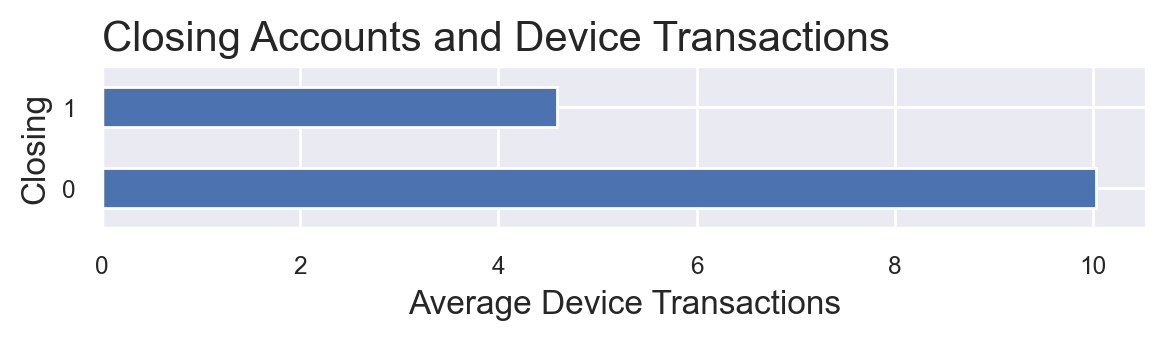

In [77]:
# create a horizontal bar plot showing the average device transactions count for remaining and closing accounts
device_transact.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Device Transactions', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Device Transactions', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [78]:
# display the average trading activities for remaining and closing accounts
trading_activity = df.groupby('flag_closure_request')[['num_trading_activities_count']].mean()
trading_activity

num_trading_activities_count
flag_closure_request                              
0                                        15.150551
1                                        12.572016

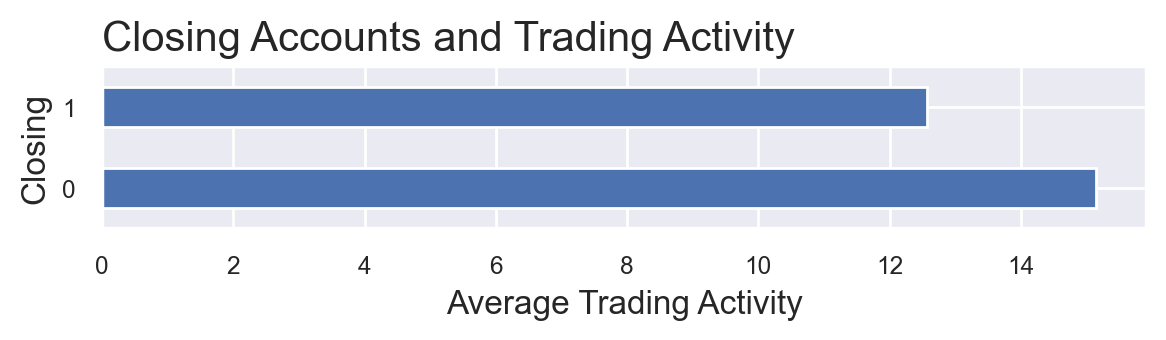

In [79]:
# create a horizontal bar plot showing the average trading activities for remaining and closing accounts
trading_activity.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Trading Activity', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Trading Activity', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [80]:
# display the average change in services for remaining and closing accounts
change_services = df.groupby('flag_closure_request')[['num_change_services']].mean()
change_services

num_change_services
flag_closure_request                     
0                                0.201606
1                               -0.937042

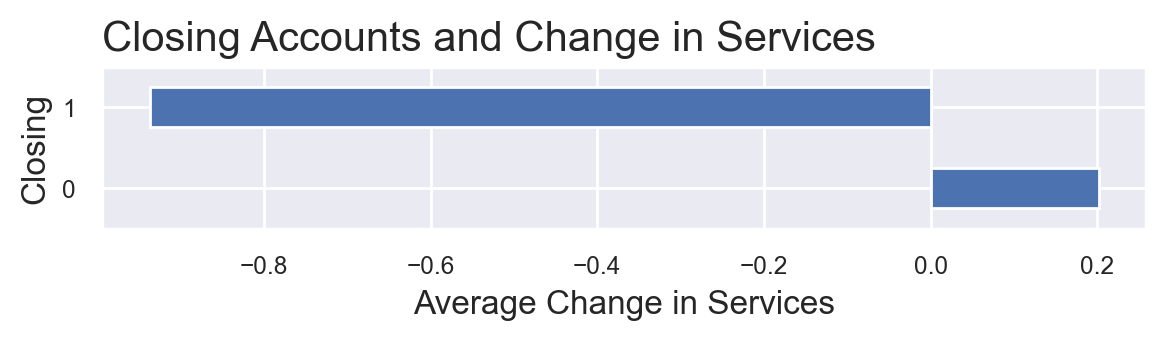

In [81]:
# create a horizontal bar plot showing the average change in services for remaining and closing accounts
change_services.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Change in Services', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Change in Services', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [82]:
# display the average loyalty points for remaining and closing accounts
loyalty_points = df.groupby('flag_closure_request')[['num_loyalty_points']].mean()
loyalty_points

num_loyalty_points
flag_closure_request                    
0                            1047.426790
1                             376.180758

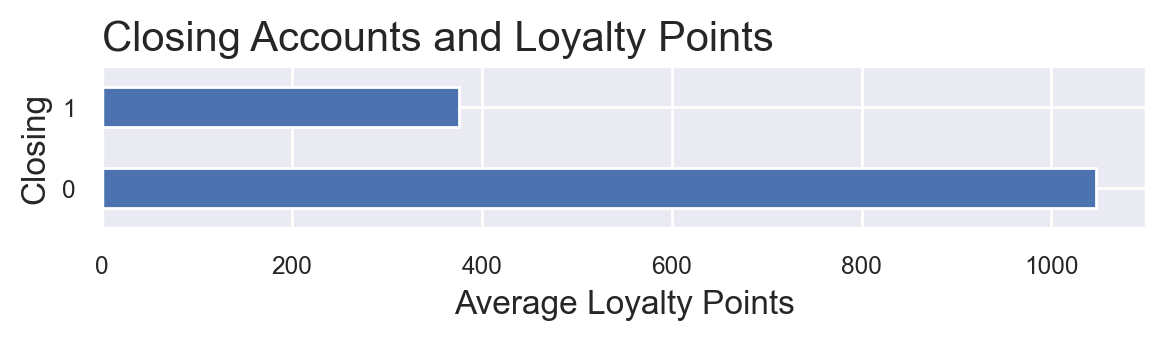

In [83]:
# create a horizontal bar plot showing the average loyalty points for remaining and closing accounts
loyalty_points.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Loyalty Points', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Loyalty Points', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [84]:
# display the average current liquidity for remaining and closing accounts
current_liquidity = df.groupby('flag_closure_request')[['amt_current_liquidity']].mean()
current_liquidity

amt_current_liquidity
flag_closure_request                       
0                              15196.768151
1                               3400.433949

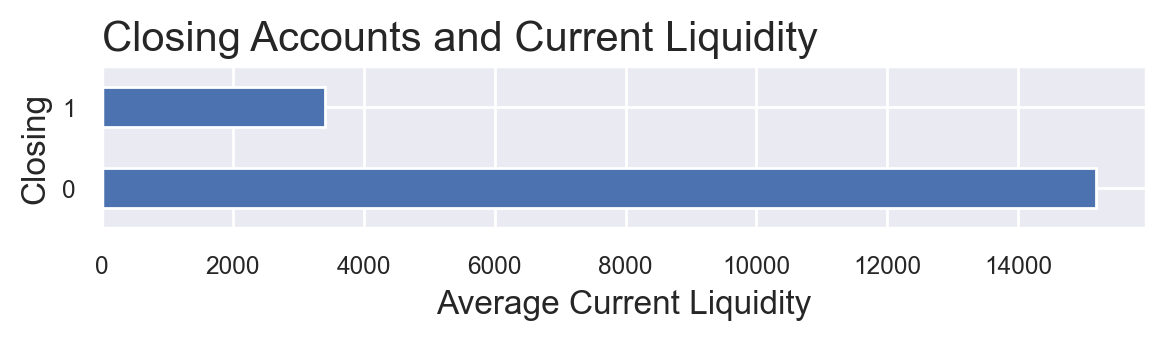

In [85]:
# create a horizontal bar plot showing the average current liquidity for remaining and closing accounts
current_liquidity.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Current Liquidity', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Current Liquidity', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [86]:
# display the average current managed for remaining and closing accounts
current_managed = df.groupby('flag_closure_request')[['amt_current_managed']].mean()
current_managed

amt_current_managed
flag_closure_request                     
0                            67773.529908
1                            36496.874531

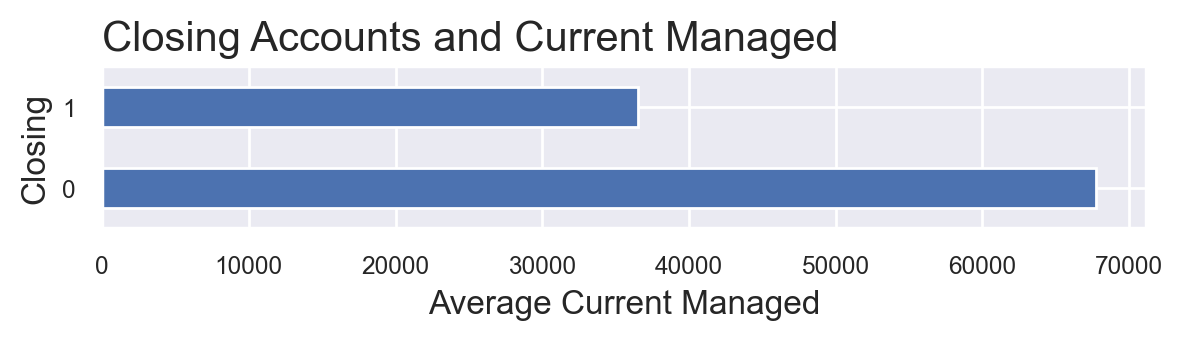

In [87]:
# create a horizontal bar plot showing the average current managed for remaining and closing accounts
current_managed.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Current Managed', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Current Managed', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [88]:
# display the average current administered for remaining and closing accounts
current_administered = df.groupby('flag_closure_request')[['amt_current_administered']].mean()
current_administered

amt_current_administered
flag_closure_request                          
0                                 76256.587151
1                                 27577.470023

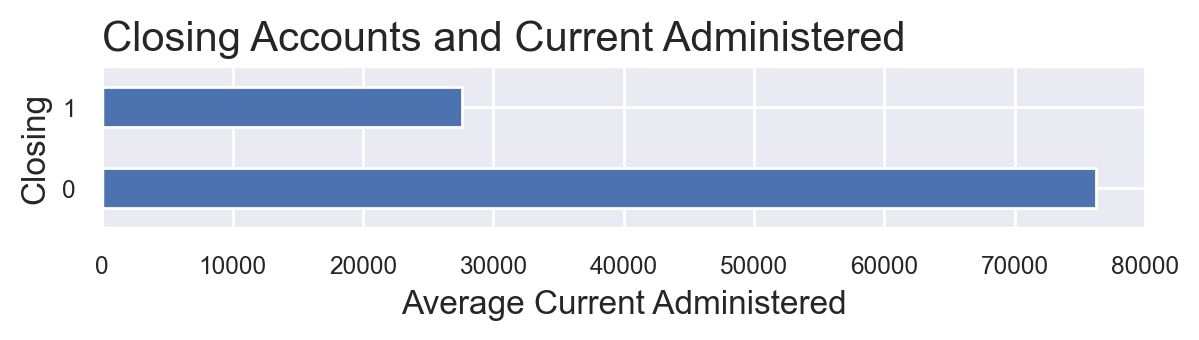

In [89]:
# create a horizontal bar plot showing the average current administered for remaining and closing accounts
current_administered.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and Current Administered', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average Current Administered', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [90]:
# display the average 6 months liquidity for remaining and closing accounts
avg_6m_liquidity = df.groupby('flag_closure_request')[['amt_6m_current_liquidity']].mean()
avg_6m_liquidity

amt_6m_current_liquidity
flag_closure_request                          
0                                 15361.551657
1                                  7614.225784

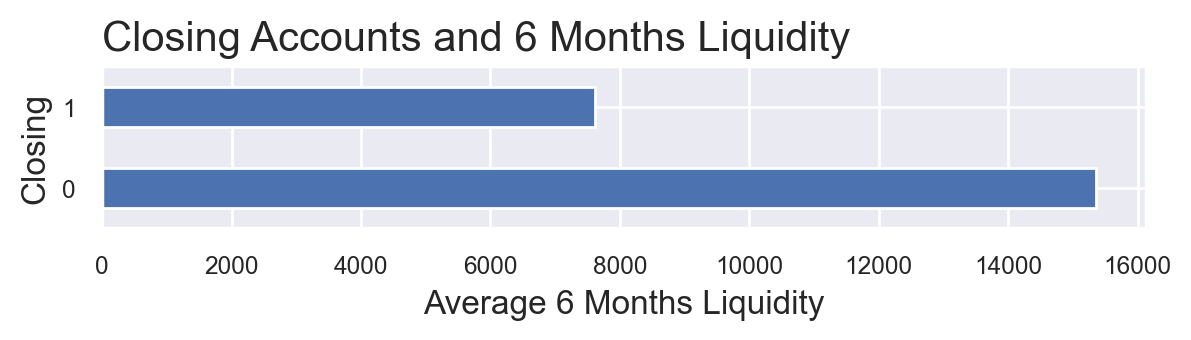

In [91]:
# create a horizontal bar plot showing the average 6 months liquidity for remaining and closing accounts
avg_6m_liquidity.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and 6 Months Liquidity', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average 6 Months Liquidity', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [92]:
# display the average 6 months managed for remaining and closing accounts
avg_6m_managed = df.groupby('flag_closure_request')[['amt_6m_current_managed']].mean()
avg_6m_managed

amt_6m_current_managed
flag_closure_request                        
0                               65565.249894
1                               61198.614220

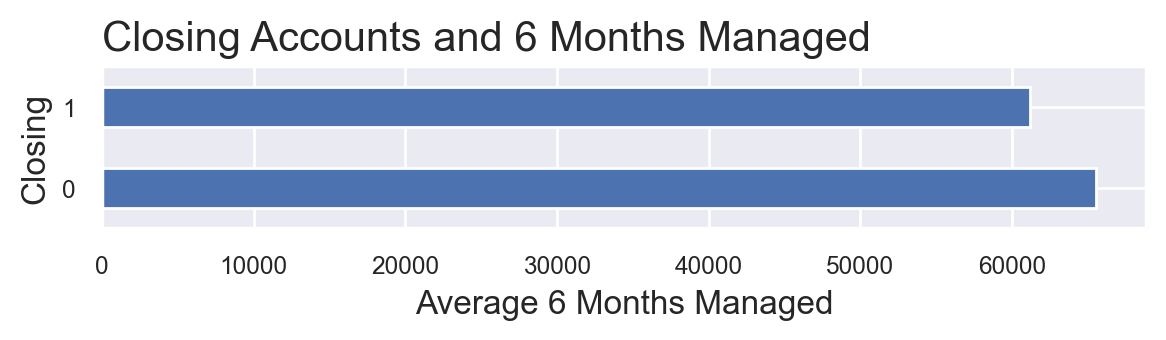

In [93]:
# create a horizontal bar plot showing the average 6 months managed for remaining and closing accounts
avg_6m_managed.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and 6 Months Managed', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average 6 Months Managed', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [94]:
# display the average 6 months administered for remaining and closing accounts
avg_6m_administered = df.groupby('flag_closure_request')[['amt_6m_current_administered']].mean()
avg_6m_administered

amt_6m_current_administered
flag_closure_request                             
0                                    72368.107375
1                                    65287.821340

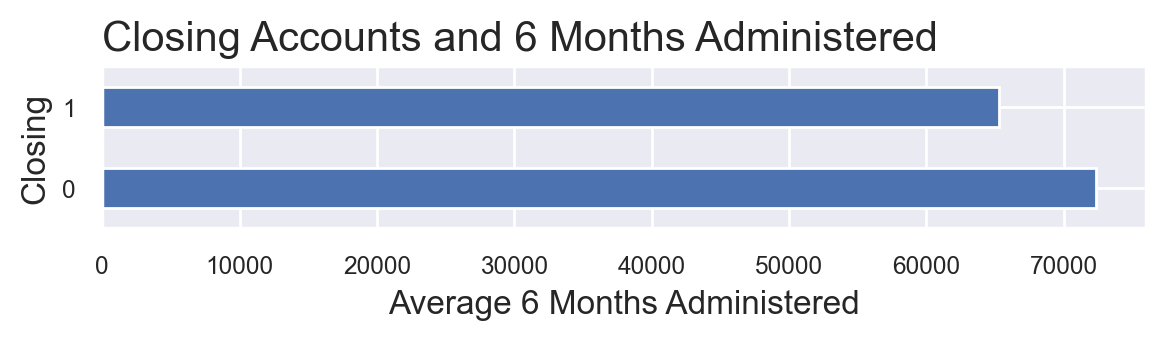

In [95]:
# create a horizontal bar plot showing the average 6 months administered for remaining and closing accounts
avg_6m_administered.plot(kind='barh', rot=0, figsize=(6,1))
plt.title('Closing Accounts and 6 Months Administered', loc='left', fontsize = 15)
plt.ylabel('Closing', fontsize = 12)
plt.xlabel('Average 6 Months Administered', fontsize = 12)

plt.legend('', frameon=False)

plt.show()

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377369 entries, 0 to 377368
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   flag_closure_request             377369 non-null  int64  
 1   amt_cust_value                   377369 non-null  float64
 2   flag_online_acc_opening          377369 non-null  int64  
 3   flag_mult_account_ownership      377369 non-null  int64  
 4   num_cust_age                     377362 non-null  float64
 5   prov_domicile                    356181 non-null  object 
 6   prov_residence                   357897 non-null  object 
 7   num_first_account_open_year      377369 non-null  int64  
 8   cust_profession                  341172 non-null  object 
 9   cust_income                      377369 non-null  int64  
 10  cust_type                        377369 non-null  int64  
 11  cust_gender                      377362 non-null  object 
 12  mi

## Contingency Tables

A **contingency table** is a type of table in a matrix format that displays the multivariate frequency distribution of the variables, and is one of the most common techniques for exploring the relationships between two variables.  
  
  <br/><br/>

In [97]:
# calculate row margins
online_acc_opening_ctab = pd.crosstab(df['flag_online_acc_opening'],
                                      df['flag_closure_request'],
                                      margins=False)

online_acc_opening_ctab['Total'] = online_acc_opening_ctab.sum(axis=1)
online_acc_opening_ctab

flag_closure_request          0     1   Total
flag_online_acc_opening                      
0                        287512  1466  288978
1                         87874   517   88391

In [98]:
# calculate row percentages
online_acc_opening_perc = online_acc_opening_ctab.div(online_acc_opening_ctab['Total'], axis=0) * 100
online_acc_opening_perc

flag_closure_request             0         1  Total
flag_online_acc_opening                            
0                        99.492695  0.507305  100.0
1                        99.415099  0.584901  100.0

In [99]:
# calculate row margins
mult_account_ownership_ctab = pd.crosstab(df['flag_mult_account_ownership'],
                                          df['flag_closure_request'],
                                          margins=False)

mult_account_ownership_ctab['Total'] = mult_account_ownership_ctab.sum(axis=1)
online_acc_opening_ctab

flag_closure_request          0     1   Total
flag_online_acc_opening                      
0                        287512  1466  288978
1                         87874   517   88391

In [100]:
# calculate row percentages
mult_account_ownership_perc = mult_account_ownership_ctab.div(mult_account_ownership_ctab['Total'], axis=0) * 100
mult_account_ownership_perc

flag_closure_request                 0         1  Total
flag_mult_account_ownership                            
0                            99.488390  0.511610  100.0
1                            99.295255  0.704745  100.0

In [101]:
# calculate row margins
prov_domicile_ctab = pd.crosstab(df['prov_domicile'],
                                 df['flag_closure_request'],
                                 margins=False)

prov_domicile_ctab['Total'] = prov_domicile_ctab.sum(axis=1)
prov_domicile_ctab

flag_closure_request      0    1  Total
prov_domicile                          
8N                        1    0      1
AG                     1158    4   1162
AL                     2050    8   2058
AN                     3472   22   3494
AO                      565    4    569
AP                      836    4    840
AQ                     1216    8   1224
AR                     1935    8   1943
AT                      993    9   1002
AV                     2169   10   2179
BA                     3661   25   3686
BE                        1    0      1
BG                     7785   41   7826
BI                     1240    9   1249
BL                      852    3    855
BN                      769    2    771
BO                     7601   35   7636
BR                      720    3    723
BS                    10297   54  10351
BT                      759    4    763
BZ                     1234    2   1236
CA                     3675   32   3707
CB                      681    4    685
CE                     5105   22   5127
CH                     2185   13   2198
CI                      277    5    282
CL                      573    7    580
CN                     1694   11   1705
CO                     3012   12   3024
CR                     1645    5   1650
CS                     1318    8   1326
CT                     7052   40   7092
CZ                      842    3    845
EE                      781    5    786
EN                      530    1    531
FC                     2088   11   2099
FE                     2331    6   2337
FG                      940    7    947
FI                     6901   37   6938
FM                     1186    8   1194
FO                       29    0     29
FR                     4134   16   4150
GE                     8498   33   8531
GO                      559    1    560
GR                      991    4    995
IM                      794    8    802
IS                      211    1    212
KR                      214    3    217
LC                     1537    8   1545
LE                     3386   18   3404
LI                     2029   18   2047
LO                      968    4    972
LT                     4558   26   4584
LU                     2316   11   2327
MB                     6257   38   6295
MC                     1894   12   1906
ME                     2790   17   2807
MI                    31263  147  31410
MN                     1775    7   1782
MO                     4230   21   4251
MS                     1447    8   1455
MT                      379    0    379
NO                     2231   20   2251
NU                      240    3    243
OG                       49    2     51
OR                      504    4    508
OT                      315    3    318
PA                     6737   45   6782
PC                     1518    4   1522
PD                     4996   31   5027
PE                     1594   11   1605
PG                     3980   17   3997
PI                     2493   11   2504
PN                     1725    1   1726
PO                     2211    9   2220
PR                     3007   28   3035
PS                       26    0     26
PT                     1884    5   1889
PU                     2400   12   2412
PV                     4119   23   4142
PZ                     1235    8   1243
RA                     2037    8   2045
RC                     2258    5   2263
RE                     3860   17   3877
RG                     1431    9   1440
RI                      979    2    981
RM                    52439  244  52683
RN                     2687    8   2695
RO                      979    5    984
SA                     6454   35   6489
SI                     1070    4   1074
SO                      507    1    508
SP                     2560   18   2578
SR                     3311   15   3326
SS                      809    5    814
SV                     2378   16   2394
TA                     2546   18   2564
TE                     1299   20   1319


In [102]:
# calculate row percentages
prov_domicile_perc = prov_domicile_ctab.div(prov_domicile_ctab['Total'], axis=0) * 100
prov_domicile_perc

flag_closure_request           0         1  Total
prov_domicile                                    
8N                    100.000000  0.000000  100.0
AG                     99.655766  0.344234  100.0
AL                     99.611273  0.388727  100.0
AN                     99.370349  0.629651  100.0
AO                     99.297012  0.702988  100.0
AP                     99.523810  0.476190  100.0
AQ                     99.346405  0.653595  100.0
AR                     99.588266  0.411734  100.0
AT                     99.101796  0.898204  100.0
AV                     99.541074  0.458926  100.0
BA                     99.321758  0.678242  100.0
BE                    100.000000  0.000000  100.0
BG                     99.476105  0.523895  100.0
BI                     99.279424  0.720576  100.0
BL                     99.649123  0.350877  100.0
BN                     99.740597  0.259403  100.0
BO                     99.541645  0.458355  100.0
BR                     99.585062  0.414938  100.0
BS                     99.478311  0.521689  100.0
BT                     99.475754  0.524246  100.0
BZ                     99.838188  0.161812  100.0
CA                     99.136768  0.863232  100.0
CB                     99.416058  0.583942  100.0
CE                     99.570899  0.429101  100.0
CH                     99.408553  0.591447  100.0
CI                     98.226950  1.773050  100.0
CL                     98.793103  1.206897  100.0
CN                     99.354839  0.645161  100.0
CO                     99.603175  0.396825  100.0
CR                     99.696970  0.303030  100.0
CS                     99.396682  0.603318  100.0
CT                     99.435984  0.564016  100.0
CZ                     99.644970  0.355030  100.0
EE                     99.363868  0.636132  100.0
EN                     99.811676  0.188324  100.0
FC                     99.475941  0.524059  100.0
FE                     99.743261  0.256739  100.0
FG                     99.260824  0.739176  100.0
FI                     99.466705  0.533295  100.0
FM                     99.329983  0.670017  100.0
FO                    100.000000  0.000000  100.0
FR                     99.614458  0.385542  100.0
GE                     99.613175  0.386825  100.0
GO                     99.821429  0.178571  100.0
GR                     99.597990  0.402010  100.0
IM                     99.002494  0.997506  100.0
IS                     99.528302  0.471698  100.0
KR                     98.617512  1.382488  100.0
LC                     99.482201  0.517799  100.0
LE                     99.471210  0.528790  100.0
LI                     99.120664  0.879336  100.0
LO                     99.588477  0.411523  100.0
LT                     99.432810  0.567190  100.0
LU                     99.527288  0.472712  100.0
MB                     99.396346  0.603654  100.0
MC                     99.370409  0.629591  100.0
ME                     99.394371  0.605629  100.0
MI                     99.531996  0.468004  100.0
MN                     99.607183  0.392817  100.0
MO                     99.505999  0.494001  100.0
MS                     99.450172  0.549828  100.0
MT                    100.000000  0.000000  100.0
NO                     99.111506  0.888494  100.0
NU                     98.765432  1.234568  100.0
OG                     96.078431  3.921569  100.0
OR                     99.212598  0.787402  100.0
OT                     99.056604  0.943396  100.0
PA                     99.336479  0.663521  100.0
PC                     99.737188  0.262812  100.0
PD                     99.383330  0.616670  100.0
PE                     99.314642  0.685358  100.0
PG                     99.574681  0.425319  100.0
PI                     99.560703  0.439297  100.0
PN                     99.942063  0.057937  100.0
PO                     99.594595  0.405405  100.0
PR                     99.077430  0.922570  100.0
PS                    100.000000  0.000000  100.0
PT                     99.735310  0.264690  100.0


In [103]:
# calculate row margins
prov_residence_ctab = pd.crosstab(df['prov_residence'],
                                  df['flag_closure_request'],
                                  margins=False)

prov_residence_ctab['Total'] = prov_residence_ctab.sum(axis=1)
prov_residence_ctab

flag_closure_request      0    1  Total
prov_residence                         
AG                     1307    4   1311
AL                     2125    8   2133
AN                     3473   21   3494
AO                      611    4    615
AP                      852    4    856
AQ                     1391   10   1401
AR                     1975   10   1985
AT                     1007   10   1017
AV                     2352   12   2364
BA                     3907   27   3934
BG                     7789   43   7832
BI                     1262    8   1270
BL                      894    3    897
BN                      888    3    891
BO                     7246   37   7283
BR                      838    3    841
BS                    10339   55  10394
BT                      840    3    843
BZ                     1329    3   1332
CA                     3807   35   3842
CB                      782    5    787
CE                     5200   24   5224
CH                     2322   13   2335
CI                      296    5    301
CL                      652    7    659
CN                     1715    9   1724
CO                     3043   12   3055
CR                     1576    4   1580
CS                     1668   11   1679
CT                     7266   40   7306
CZ                      982    3    985
EE                      241    0    241
EN                      579    2    581
FC                     2100   10   2110
FE                     2389    8   2397
FG                     1148    7   1155
FI                     6696   37   6733
FM                     1212    9   1221
FO                        1    0      1
FR                     4281   16   4297
GE                     8582   34   8616
GO                      579    1    580
GR                     1054    5   1059
IM                      856    7    863
IS                      269    1    270
KR                      293    3    296
LC                     1570    7   1577
LE                     3684   20   3704
LI                     2089   18   2107
LO                      968    2    970
LT                     4751   26   4777
LU                     2348   11   2359
MB                     6072   35   6107
MC                     1940   14   1954
ME                     3017   18   3035
MI                    28939  146  29085
MN                     1827    6   1833
MO                     4169   23   4192
MS                     1500    9   1509
MT                      523    0    523
NO                     2234   18   2252
NU                      311    3    314
OG                       67    2     69
OR                      549    3    552
OT                      367    3    370
PA                     6975   47   7022
PC                     1514    4   1518
PD                     5047   31   5078
PE                     1666   12   1678
PG                     4132   17   4149
PI                     2417   11   2428
PN                     1793    1   1794
PO                     2177    9   2186
PR                     3007   27   3034
PS                        2    0      2
PT                     1886    5   1891
PU                     2441   12   2453
PV                     4028   23   4051
PZ                     1486   12   1498
RA                     2061    7   2068
RC                     2461    7   2468
RE                     3869   17   3886
RG                     1524    9   1533
RI                     1067    3   1070
RM                    50123  230  50353
RN                     2668    8   2676
RO                     1008    4   1012
SA                     6875   35   6910
SI                     1050    4   1054
SO                      543    1    544
SP                     2577   16   2593
SR                     3493   17   3510
SS                      926    6    932
SV                     2444   17   2461
TA                     2768   18   2786
TE                     1368   20   1388
TN                     1707   10   1717
TO                    19831  107  19938


In [104]:
# calculate row percentages
prov_residence_perc = prov_residence_ctab.div(prov_residence_ctab['Total'], axis=0) * 100
prov_residence_perc

flag_closure_request           0         1  Total
prov_residence                                   
AG                     99.694889  0.305111  100.0
AL                     99.624941  0.375059  100.0
AN                     99.398970  0.601030  100.0
AO                     99.349593  0.650407  100.0
AP                     99.532710  0.467290  100.0
AQ                     99.286224  0.713776  100.0
AR                     99.496222  0.503778  100.0
AT                     99.016716  0.983284  100.0
AV                     99.492386  0.507614  100.0
BA                     99.313676  0.686324  100.0
BG                     99.450970  0.549030  100.0
BI                     99.370079  0.629921  100.0
BL                     99.665552  0.334448  100.0
BN                     99.663300  0.336700  100.0
BO                     99.491968  0.508032  100.0
BR                     99.643282  0.356718  100.0
BS                     99.470849  0.529151  100.0
BT                     99.644128  0.355872  100.0
BZ                     99.774775  0.225225  100.0
CA                     99.089016  0.910984  100.0
CB                     99.364676  0.635324  100.0
CE                     99.540582  0.459418  100.0
CH                     99.443255  0.556745  100.0
CI                     98.338870  1.661130  100.0
CL                     98.937785  1.062215  100.0
CN                     99.477958  0.522042  100.0
CO                     99.607201  0.392799  100.0
CR                     99.746835  0.253165  100.0
CS                     99.344848  0.655152  100.0
CT                     99.452505  0.547495  100.0
CZ                     99.695431  0.304569  100.0
EE                    100.000000  0.000000  100.0
EN                     99.655766  0.344234  100.0
FC                     99.526066  0.473934  100.0
FE                     99.666249  0.333751  100.0
FG                     99.393939  0.606061  100.0
FI                     99.450468  0.549532  100.0
FM                     99.262899  0.737101  100.0
FO                    100.000000  0.000000  100.0
FR                     99.627647  0.372353  100.0
GE                     99.605385  0.394615  100.0
GO                     99.827586  0.172414  100.0
GR                     99.527856  0.472144  100.0
IM                     99.188876  0.811124  100.0
IS                     99.629630  0.370370  100.0
KR                     98.986486  1.013514  100.0
LC                     99.556119  0.443881  100.0
LE                     99.460043  0.539957  100.0
LI                     99.145705  0.854295  100.0
LO                     99.793814  0.206186  100.0
LT                     99.455725  0.544275  100.0
LU                     99.533701  0.466299  100.0
MB                     99.426887  0.573113  100.0
MC                     99.283521  0.716479  100.0
ME                     99.406919  0.593081  100.0
MI                     99.498023  0.501977  100.0
MN                     99.672668  0.327332  100.0
MO                     99.451336  0.548664  100.0
MS                     99.403579  0.596421  100.0
MT                    100.000000  0.000000  100.0
NO                     99.200710  0.799290  100.0
NU                     99.044586  0.955414  100.0
OG                     97.101449  2.898551  100.0
OR                     99.456522  0.543478  100.0
OT                     99.189189  0.810811  100.0
PA                     99.330675  0.669325  100.0
PC                     99.736495  0.263505  100.0
PD                     99.389523  0.610477  100.0
PE                     99.284863  0.715137  100.0
PG                     99.590263  0.409737  100.0
PI                     99.546952  0.453048  100.0
PN                     99.944259  0.055741  100.0
PO                     99.588289  0.411711  100.0
PR                     99.110086  0.889914  100.0
PS                    100.000000  0.000000  100.0
PT                     99.735590  0.264410  100.0
PU                     99.510803  0.489197  100.0
PV                     99.432239  0.567761  100.0


In [105]:
# calculate row margins
cust_profession_ctab = pd.crosstab(df['cust_profession'],
                                 df['flag_closure_request'],
                                 margins=False)

cust_profession_ctab['Total'] = cust_profession_ctab.sum(axis=1)
cust_profession_ctab

flag_closure_request                            0    1   Total
cust_profession                                               
Altro/Nessuno                               70465  471   70936
Autotrasportatore                             815    6     821
Avvocato                                     5083   24    5107
Commercialista                               4068   21    4089
Commesso/Ausiliario                          2534   15    2549
Dirigente                                   14192   54   14246
Docente/Insegnante                          13164   56   13220
Impiegato                                  104340  421  104761
Ingegnere/Architetto                        14870   51   14921
Libero professionista/Titolare di impresa   51151  287   51438
Libero professionista/Titolare impresa        294    1     295
Medico/Farmacista                            9252   31    9283
Notaio                                        177    1     178
Operaio                                     16970   95   17065
Quadro                                      16559   38   16597
Rappresentante/Agente                        5662   26    5688
Ufficiale/Sottoufficiale                        4    0       4
Ufficiale/Sottufficiale                      9950   24    9974

In [106]:
# calculate row percentages
cust_profession_perc = cust_profession_ctab.div(cust_profession_ctab['Total'], axis=0) * 100
cust_profession_perc

flag_closure_request                                0         1  Total
cust_profession                                                       
Altro/Nessuno                               99.336021  0.663979  100.0
Autotrasportatore                           99.269184  0.730816  100.0
Avvocato                                    99.530057  0.469943  100.0
Commercialista                              99.486427  0.513573  100.0
Commesso/Ausiliario                         99.411534  0.588466  100.0
Dirigente                                   99.620946  0.379054  100.0
Docente/Insegnante                          99.576399  0.423601  100.0
Impiegato                                   99.598133  0.401867  100.0
Ingegnere/Architetto                        99.658200  0.341800  100.0
Libero professionista/Titolare di impresa   99.442047  0.557953  100.0
Libero professionista/Titolare impresa      99.661017  0.338983  100.0
Medico/Farmacista                           99.666056  0.333944  100.0
Notaio                                      99.438202  0.561798  100.0
Operaio                                     99.443305  0.556695  100.0
Quadro                                      99.771043  0.228957  100.0
Rappresentante/Agente                       99.542897  0.457103  100.0
Ufficiale/Sottoufficiale                   100.000000  0.000000  100.0
Ufficiale/Sottufficiale                     99.759374  0.240626  100.0

In [107]:
# calculate row margins
cust_income_ctab = pd.crosstab(df['cust_income'],
                               df['flag_closure_request'],
                               margins=False)

cust_income_ctab['Total'] = cust_income_ctab.sum(axis=1)
cust_income_ctab

flag_closure_request       0     1   Total
cust_income                               
0                     218244  1649  219893
1                      25614    67   25681
2                      25306    74   25380
3                      28945    54   28999
4                      45036    88   45124
5                      32241    51   32292

In [108]:
# calculate row percentages
cust_income_perc = cust_income_ctab.div(cust_income_ctab['Total'], axis=0) * 100
cust_income_perc

flag_closure_request          0         1  Total
cust_income                                     
0                     99.250090  0.749910  100.0
1                     99.739107  0.260893  100.0
2                     99.708432  0.291568  100.0
3                     99.813787  0.186213  100.0
4                     99.804982  0.195018  100.0
5                     99.842066  0.157934  100.0

In [109]:
# calculate row margins
cust_type_ctab = pd.crosstab(df['cust_type'],
                             df['flag_closure_request'],
                             margins=False)

cust_type_ctab['Total'] = cust_type_ctab.sum(axis=1)
cust_type_ctab

flag_closure_request       0     1   Total
cust_type                                 
0                      13927   178   14105
1                      17439    25   17464
2                       4598     6    4604
3                     147276   418  147694
4                     192146  1356  193502

In [110]:
# calculate row percentages
cust_type_perc = cust_type_ctab.div(cust_type_ctab['Total'], axis=0) * 100
cust_type_perc

flag_closure_request          0         1  Total
cust_type                                       
0                     98.738036  1.261964  100.0
1                     99.856848  0.143152  100.0
2                     99.869679  0.130321  100.0
3                     99.716982  0.283018  100.0
4                     99.299232  0.700768  100.0

In [111]:
# calculate row margins
cust_gender_ctab = pd.crosstab(df['cust_gender'],
                               df['flag_closure_request'],
                               margins=False)

cust_gender_ctab['Total'] = cust_gender_ctab.sum(axis=1)
cust_gender_ctab

flag_closure_request       0     1   Total
cust_gender                               
F                     111595   735  112330
M                     263784  1248  265032

In [112]:
# calculate row percentages
cust_gender_perc = cust_gender_ctab.div(cust_gender_ctab['Total'], axis=0) * 100
cust_gender_perc

flag_closure_request          0         1  Total
cust_gender                                     
F                     99.345678  0.654322  100.0
M                     99.529113  0.470887  100.0

In [113]:
# calculate row margins
mifid_profile_ctab = pd.crosstab(df['mifid_profile'],
                                 df['flag_closure_request'],
                                 margins=False)

mifid_profile_ctab['Total'] = mifid_profile_ctab.sum(axis=1)
mifid_profile_ctab

flag_closure_request       0    1   Total
mifid_profile                            
0                      48933  324   49257
1                      58540  266   58806
2                      12644   48   12692
3                      61029  311   61340
4                      79138  421   79559
5                     115102  613  115715

In [114]:
# calculate row percentages
mifid_profile_perc = mifid_profile_ctab.div(mifid_profile_ctab['Total'], axis=0) * 100
mifid_profile_perc

flag_closure_request          0         1  Total
mifid_profile                                   
0                     99.342225  0.657775  100.0
1                     99.547665  0.452335  100.0
2                     99.621809  0.378191  100.0
3                     99.492990  0.507010  100.0
4                     99.470833  0.529167  100.0
5                     99.470250  0.529750  100.0

In [115]:
# calculate row margins
mortgage_ctab = pd.crosstab(df['flag_mortgage'],
                            df['flag_closure_request'],
                            margins=False)

mortgage_ctab['Total'] = mortgage_ctab.sum(axis=1)
mortgage_ctab

flag_closure_request       0     1   Total
flag_mortgage                             
0                     374569  1983  376552
1                        817     0     817

In [116]:
# calculate row percentages
mortgage_perc = mortgage_ctab.div(mortgage_ctab['Total'], axis=0) * 100
mortgage_perc

flag_closure_request          0        1  Total
flag_mortgage                                  
0                      99.47338  0.52662  100.0
1                     100.00000  0.00000  100.0

In [117]:
# calculate row margins
loan_ctab = pd.crosstab(df['flag_loan'],
                        df['flag_closure_request'],
                        margins=False)

loan_ctab['Total'] = loan_ctab.sum(axis=1)
loan_ctab

flag_closure_request       0     1   Total
flag_loan                                 
0                     364222  1982  366204
1                      11164     1   11165

In [118]:
# calculate row percentages
loan_perc = loan_ctab.div(loan_ctab['Total'], axis=0) * 100
loan_perc

flag_closure_request          0         1  Total
flag_loan                                       
0                     99.458772  0.541228  100.0
1                     99.991043  0.008957  100.0

In [119]:
# calculate row margins
internal_tranfers_ctab = pd.crosstab(df['flag_internal_tranfers'],
                                     df['flag_closure_request'],
                                     margins=False)

internal_tranfers_ctab['Total'] = internal_tranfers_ctab.sum(axis=1)
internal_tranfers_ctab

flag_closure_request         0     1   Total
flag_internal_tranfers                      
0                       319381  1567  320948
1                        56005   416   56421

In [120]:
# calculate row percentages
internal_tranfers_perc = internal_tranfers_ctab.div(internal_tranfers_ctab['Total'], axis=0) * 100
internal_tranfers_perc

flag_closure_request            0         1  Total
flag_internal_tranfers                            
0                       99.511759  0.488241  100.0
1                       99.262686  0.737314  100.0

In [121]:
# calculate row margins
info_closure_request_ctab = pd.crosstab(df['flag_info_closure_request'],
                                        df['flag_closure_request'],
                                        margins=False)

info_closure_request_ctab['Total'] = info_closure_request_ctab.sum(axis=1)
info_closure_request_ctab

flag_closure_request            0     1   Total
flag_info_closure_request                      
0                          375165  1975  377140
1                             221     8     229

In [122]:
# calculate row percentages
info_closure_request_perc = info_closure_request_ctab.div(info_closure_request_ctab['Total'], axis=0) * 100
info_closure_request_perc

flag_closure_request               0         1  Total
flag_info_closure_request                            
0                          99.476322  0.523678  100.0
1                          96.506550  3.493450  100.0

In [123]:
# calculate row margins
loyalty_program_enrol_ctab = pd.crosstab(df['flag_loyalty_program_enrol'],
                                         df['flag_closure_request'],
                                         margins=False)

loyalty_program_enrol_ctab['Total'] = loyalty_program_enrol_ctab.sum(axis=1)
loyalty_program_enrol_ctab

flag_closure_request             0     1   Total
flag_loyalty_program_enrol                      
0                           248490  1640  250130
1                           126896   343  127239

In [124]:
# calculate row percentages
loyalty_program_enrol_perc = loyalty_program_enrol_ctab.div(loyalty_program_enrol_ctab['Total'], axis=0) * 100
loyalty_program_enrol_perc

flag_closure_request                0         1  Total
flag_loyalty_program_enrol                            
0                           99.344341  0.655659  100.0
1                           99.730429  0.269571  100.0

In [125]:
# calculate row margins
outgoing_sec_tranfer_ctab = pd.crosstab(df['flag_outgoing_sec_tranfer'],
                                        df['flag_closure_request'],
                                        margins=False)

outgoing_sec_tranfer_ctab['Total'] = outgoing_sec_tranfer_ctab.sum(axis=1)
outgoing_sec_tranfer_ctab

flag_closure_request            0     1   Total
flag_outgoing_sec_tranfer                      
0                          372363  1852  374215
1                            3023   131    3154

In [126]:
# calculate row percentages
outgoing_sec_tranfer_perc = outgoing_sec_tranfer_ctab.div(outgoing_sec_tranfer_ctab['Total'], axis=0) * 100
outgoing_sec_tranfer_perc

flag_closure_request               0         1  Total
flag_outgoing_sec_tranfer                            
0                          99.505097  0.494903  100.0
1                          95.846544  4.153456  100.0

In [127]:
# calculate row margins
card_rejection_ctab = pd.crosstab(df['flag_card_rejection'],
                                  df['flag_closure_request'],
                                  margins=False)

card_rejection_ctab['Total'] = card_rejection_ctab.sum(axis=1)
card_rejection_ctab

flag_closure_request       0     1   Total
flag_card_rejection                       
0                     375043  1980  377023
1                        343     3     346

In [128]:
# calculate row percentages
card_rejection_perc = card_rejection_ctab.div(card_rejection_ctab['Total'], axis=0) * 100
card_rejection_perc

flag_closure_request          0         1  Total
flag_card_rejection                             
0                     99.474833  0.525167  100.0
1                     99.132948  0.867052  100.0

In [129]:
# calculate row margins
loan_rejection_ctab = pd.crosstab(df['flag_loan_rejection'],
                                  df['flag_closure_request'],
                                  margins=False)

loan_rejection_ctab['Total'] = loan_rejection_ctab.sum(axis=1)
loan_rejection_ctab

flag_closure_request       0     1   Total
flag_loan_rejection                       
0                     372376  1971  374347
1                       3010    12    3022

In [130]:
# calculate row percentages
loan_rejection_perc = loan_rejection_ctab.div(loan_rejection_ctab['Total'], axis=0) * 100
loan_rejection_perc

flag_closure_request          0         1  Total
flag_loan_rejection                             
0                     99.473483  0.526517  100.0
1                     99.602912  0.397088  100.0

In [131]:
# calculate row margins
rid_deactivation_ctab = pd.crosstab(df['flag_rid_deactivation'],
                                    df['flag_closure_request'],
                                    margins=False)

rid_deactivation_ctab['Total'] = rid_deactivation_ctab.sum(axis=1)
rid_deactivation_ctab

flag_closure_request        0     1   Total
flag_rid_deactivation                      
0                      375074  1976  377050
1                         312     7     319

In [132]:
# calculate row percentages
rid_deactivation_perc = rid_deactivation_ctab.div(rid_deactivation_ctab['Total'], axis=0) * 100
rid_deactivation_perc

flag_closure_request           0         1  Total
flag_rid_deactivation                            
0                      99.475932  0.524068  100.0
1                      97.805643  2.194357  100.0

In [133]:
# load the map of Italy with regions
italy_r = gpd.read_file('../maps/italy-with-regions/reg2011_g.shp')

<AxesSubplot:>

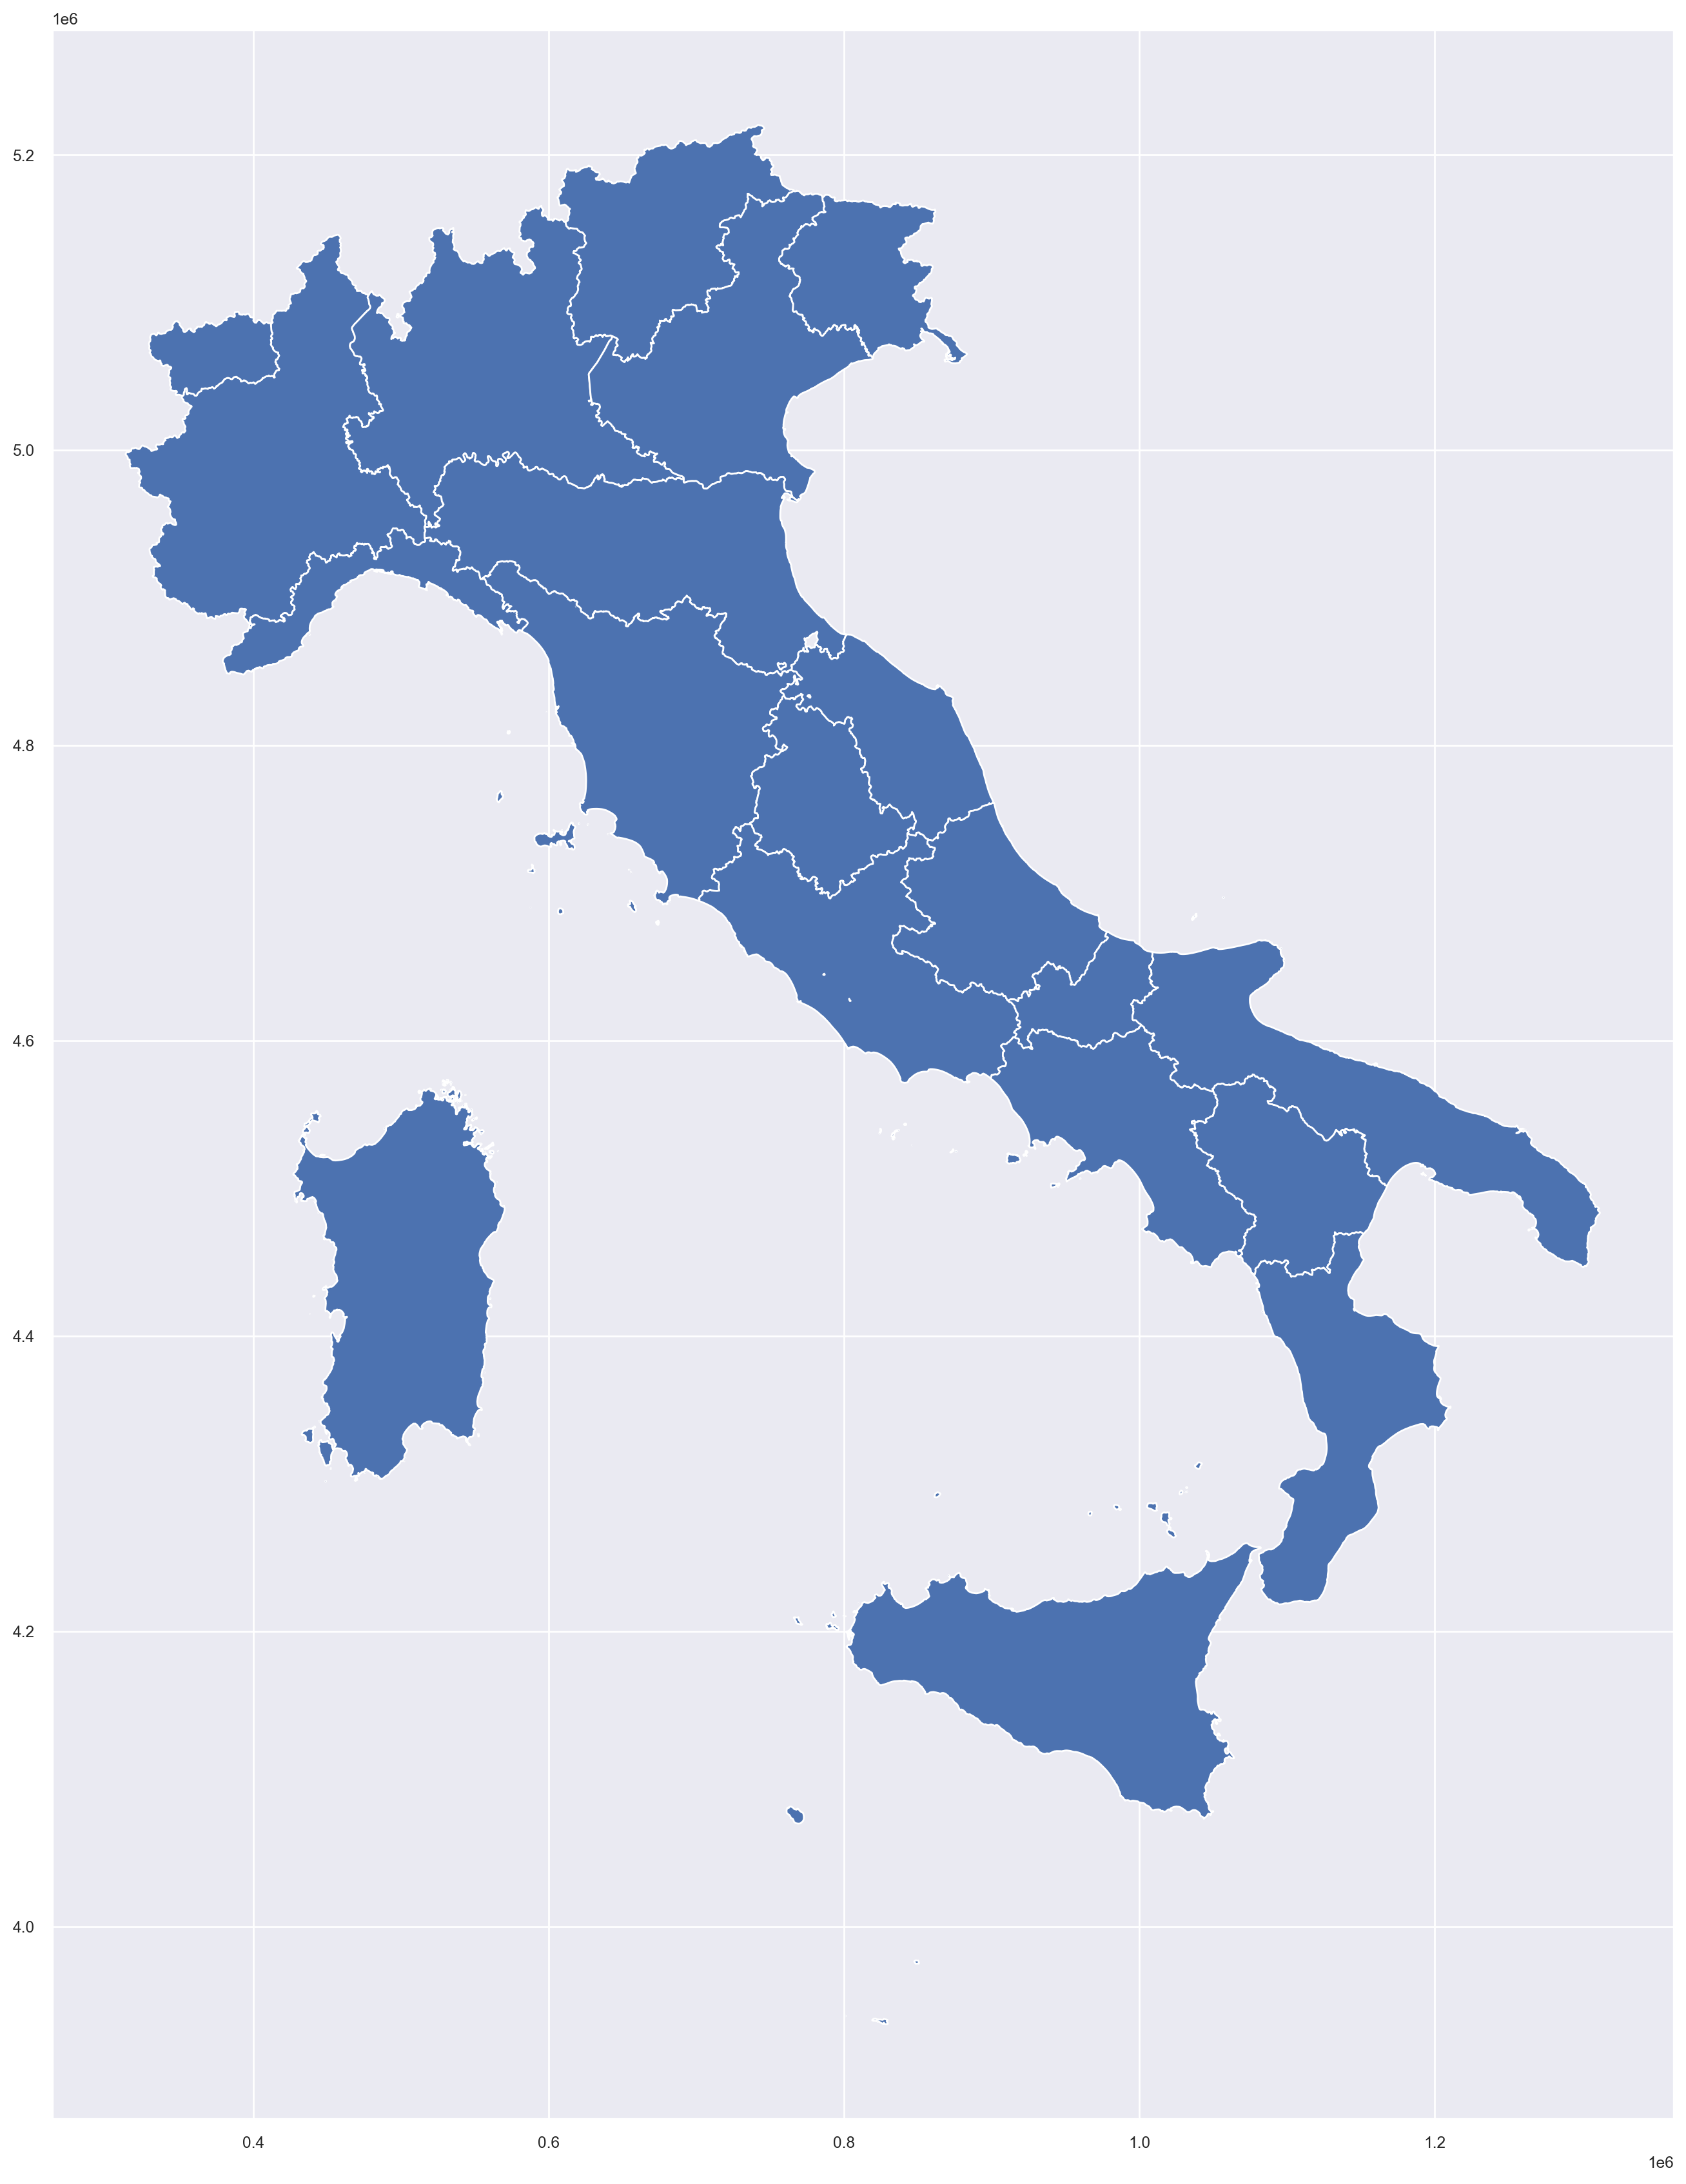

In [134]:
italy_r.plot(figsize = (20,20))

In [141]:
# load the map of Italy with provinces
italy_pr = gpd.read_file('../maps/georef-italy-provincia-millesime.shp')

<AxesSubplot:>

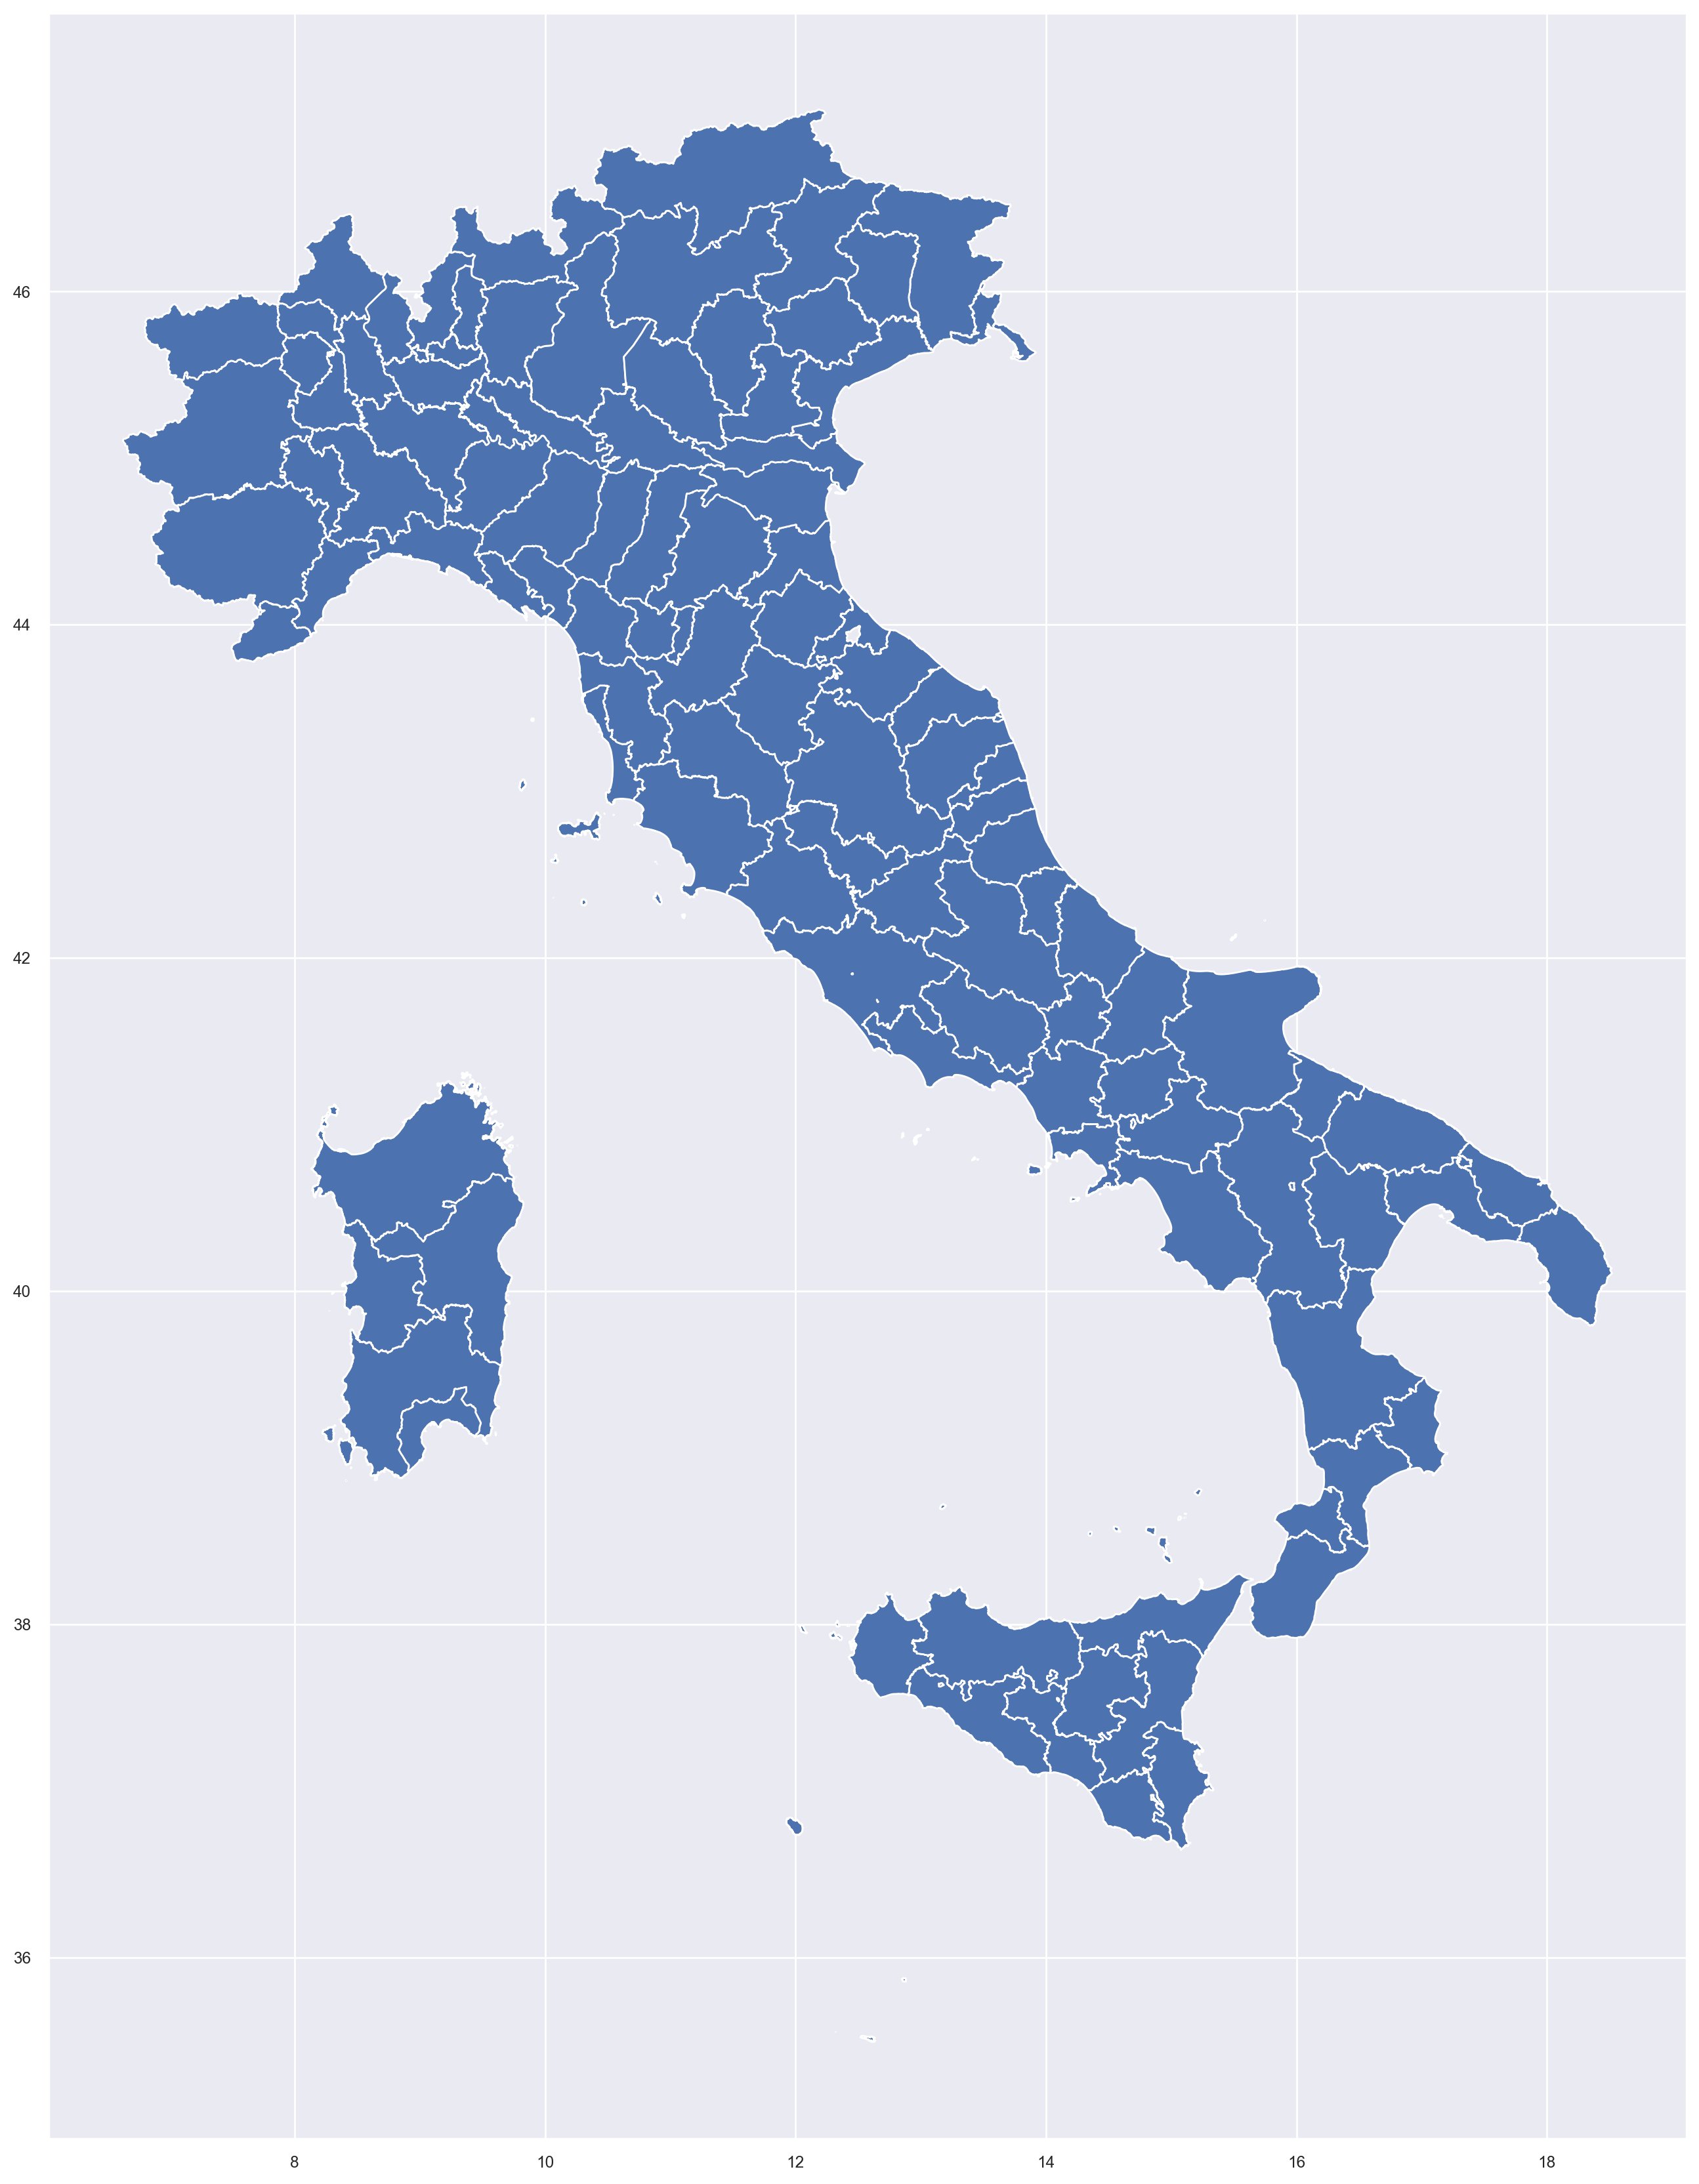

In [142]:
italy_pr.plot(figsize = (20,20))

In [143]:
italy_pr.head()

year rip_code  rip_name reg_code        reg_name prov_code  prov_name  \
0  2022        5     Isole       20        Sardegna        95   Oristano   
1  2022        2  Nord-Est        8  Emilia-Romagna        36     Modena   
2  2022        4       Sud       18        Calabria        79  Catanzaro   
3  2022        2  Nord-Est        8  Emilia-Romagna        99     Rimini   
4  2022        4       Sud       13         Abruzzo        67     Teramo   

  prov_name_u prov_name_l prov_area_c  prov_type prov_sigla  \
0    ORISTANO    oristano         ITA  Provincia         OR   
1      MODENA      modena         ITA  Provincia         MO   
2   CATANZARO   catanzaro         ITA  Provincia         CZ   
3      RIMINI      rimini         ITA  Provincia         RN   
4      TERAMO      teramo         ITA  Provincia         TE   

                                            geometry  
0  MULTIPOLYGON (((8.27581 39.88234, 8.27631 39.8...  
1  MULTIPOLYGON (((10.48041 44.1895, 10.48064 44....  
2  POLYGON ((16.41984 38.55398, 16.41962 38.55455...  
3  POLYGON ((12.45062 44.16222, 12.45209 44.16101...  
4  POLYGON ((14.14626 42.53062, 14.14517 42.53039...

In [144]:
italy_p = italy_pr.copy()

In [145]:
italy_p.head(10)

year rip_code    rip_name reg_code        reg_name prov_code  \
0  2022        5       Isole       20        Sardegna        95   
1  2022        2    Nord-Est        8  Emilia-Romagna        36   
2  2022        4         Sud       18        Calabria        79   
3  2022        2    Nord-Est        8  Emilia-Romagna        99   
4  2022        4         Sud       13         Abruzzo        67   
5  2022        1  Nord-Ovest        3       Lombardia        17   
6  2022        1  Nord-Ovest        1        Piemonte         3   
7  2022        4         Sud       15        Campania        64   
8  2022        3      Centro       11          Marche        41   
9  2022        4         Sud       15        Campania        61   

         prov_name      prov_name_u      prov_name_l prov_area_c  prov_type  \
0         Oristano         ORISTANO         oristano         ITA  Provincia   
1           Modena           MODENA           modena         ITA  Provincia   
2        Catanzaro        CATANZARO        catanzaro         ITA  Provincia   
3           Rimini           RIMINI           rimini         ITA  Provincia   
4           Teramo           TERAMO           teramo         ITA  Provincia   
5          Brescia          BRESCIA          brescia         ITA  Provincia   
6           Novara           NOVARA           novara         ITA  Provincia   
7         Avellino         AVELLINO         avellino         ITA  Provincia   
8  Pesaro e Urbino  PESARO E URBINO  pesaro e urbino         ITA  Provincia   
9          Caserta          CASERTA          caserta         ITA  Provincia   

  prov_sigla                                           geometry  
0         OR  MULTIPOLYGON (((8.27581 39.88234, 8.27631 39.8...  
1         MO  MULTIPOLYGON (((10.48041 44.1895, 10.48064 44....  
2         CZ  POLYGON ((16.41984 38.55398, 16.41962 38.55455...  
3         RN  POLYGON ((12.45062 44.16222, 12.45209 44.16101...  
4         TE  POLYGON ((14.14626 42.53062, 14.14517 42.53039...  
5         BS  POLYGON ((10.84015 45.83276, 10.83833 45.82758...  
6         NO  POLYGON ((8.34986 45.77238, 8.35145 45.77307, ...  
7         AV  POLYGON ((15.54288 41.05585, 15.54427 41.05464...  
8         PU  MULTIPOLYGON (((13.08571 43.71858, 13.08978 43...  
9         CE  POLYGON ((13.97791 41.46249, 13.97977 41.46096...

In [156]:
prov_residence_perc.reset_index(inplace=True)

In [157]:
prov_residence_perc

flag_closure_request  index prov_residence           0         1  Total
0                         0             AG   99.694889  0.305111  100.0
1                         1             AL   99.624941  0.375059  100.0
2                         2             AN   99.398970  0.601030  100.0
3                         3             AO   99.349593  0.650407  100.0
4                         4             AP   99.532710  0.467290  100.0
5                         5             AQ   99.286224  0.713776  100.0
6                         6             AR   99.496222  0.503778  100.0
7                         7             AT   99.016716  0.983284  100.0
8                         8             AV   99.492386  0.507614  100.0
9                         9             BA   99.313676  0.686324  100.0
10                       10             BG   99.450970  0.549030  100.0
11                       11             BI   99.370079  0.629921  100.0
12                       12             BL   99.665552  0.334448  100.0
13                       13             BN   99.663300  0.336700  100.0
14                       14             BO   99.491968  0.508032  100.0
15                       15             BR   99.643282  0.356718  100.0
16                       16             BS   99.470849  0.529151  100.0
17                       17             BT   99.644128  0.355872  100.0
18                       18             BZ   99.774775  0.225225  100.0
19                       19             CA   99.089016  0.910984  100.0
20                       20             CB   99.364676  0.635324  100.0
21                       21             CE   99.540582  0.459418  100.0
22                       22             CH   99.443255  0.556745  100.0
23                       23             CI   98.338870  1.661130  100.0
24                       24             CL   98.937785  1.062215  100.0
25                       25             CN   99.477958  0.522042  100.0
26                       26             CO   99.607201  0.392799  100.0
27                       27             CR   99.746835  0.253165  100.0
28                       28             CS   99.344848  0.655152  100.0
29                       29             CT   99.452505  0.547495  100.0
30                       30             CZ   99.695431  0.304569  100.0
31                       31             EE  100.000000  0.000000  100.0
32                       32             EN   99.655766  0.344234  100.0
33                       33             FC   99.526066  0.473934  100.0
34                       34             FE   99.666249  0.333751  100.0
35                       35             FG   99.393939  0.606061  100.0
36                       36             FI   99.450468  0.549532  100.0
37                       37             FM   99.262899  0.737101  100.0
38                       38             FO  100.000000  0.000000  100.0
39                       39             FR   99.627647  0.372353  100.0
40                       40             GE   99.605385  0.394615  100.0
41                       41             GO   99.827586  0.172414  100.0
42                       42             GR   99.527856  0.472144  100.0
43                       43             IM   99.188876  0.811124  100.0
44                       44             IS   99.629630  0.370370  100.0
45                       45             KR   98.986486  1.013514  100.0
46                       46             LC   99.556119  0.443881  100.0
47                       47             LE   99.460043  0.539957  100.0
48                       48             LI   99.145705  0.854295  100.0
49                       49             LO   99.793814  0.206186  100.0
50                       50             LT   99.455725  0.544275  100.0
51                       51             LU   99.533701  0.466299  100.0
52                       52             MB   99.426887  0.573113  100.0
53                       53             MC   99.283521  0.716479  100.0
54                       54             

In [170]:
# prov_residence_perc.drop('index', axis=1, inplace=True)
prov_residence_perc.rename(columns={0:'No', 1:'Yes'}, inplace=True)
# prov_residence_perc

In [171]:
prov_residence_perc

flag_closure_request prov_residence          No       Yes  Total
0                                AG   99.694889  0.305111  100.0
1                                AL   99.624941  0.375059  100.0
2                                AN   99.398970  0.601030  100.0
3                                AO   99.349593  0.650407  100.0
4                                AP   99.532710  0.467290  100.0
5                                AQ   99.286224  0.713776  100.0
6                                AR   99.496222  0.503778  100.0
7                                AT   99.016716  0.983284  100.0
8                                AV   99.492386  0.507614  100.0
9                                BA   99.313676  0.686324  100.0
10                               BG   99.450970  0.549030  100.0
11                               BI   99.370079  0.629921  100.0
12                               BL   99.665552  0.334448  100.0
13                               BN   99.663300  0.336700  100.0
14                               BO   99.491968  0.508032  100.0
15                               BR   99.643282  0.356718  100.0
16                               BS   99.470849  0.529151  100.0
17                               BT   99.644128  0.355872  100.0
18                               BZ   99.774775  0.225225  100.0
19                               CA   99.089016  0.910984  100.0
20                               CB   99.364676  0.635324  100.0
21                               CE   99.540582  0.459418  100.0
22                               CH   99.443255  0.556745  100.0
23                               CI   98.338870  1.661130  100.0
24                               CL   98.937785  1.062215  100.0
25                               CN   99.477958  0.522042  100.0
26                               CO   99.607201  0.392799  100.0
27                               CR   99.746835  0.253165  100.0
28                               CS   99.344848  0.655152  100.0
29                               CT   99.452505  0.547495  100.0
30                               CZ   99.695431  0.304569  100.0
31                               EE  100.000000  0.000000  100.0
32                               EN   99.655766  0.344234  100.0
33                               FC   99.526066  0.473934  100.0
34                               FE   99.666249  0.333751  100.0
35                               FG   99.393939  0.606061  100.0
36                               FI   99.450468  0.549532  100.0
37                               FM   99.262899  0.737101  100.0
38                               FO  100.000000  0.000000  100.0
39                               FR   99.627647  0.372353  100.0
40                               GE   99.605385  0.394615  100.0
41                               GO   99.827586  0.172414  100.0
42                               GR   99.527856  0.472144  100.0
43                               IM   99.188876  0.811124  100.0
44                               IS   99.629630  0.370370  100.0
45                               KR   98.986486  1.013514  100.0
46                               LC   99.556119  0.443881  100.0
47                               LE   99.460043  0.539957  100.0
48                               LI   99.145705  0.854295  100.0
49                               LO   99.793814  0.206186  100.0
50                               LT   99.455725  0.544275  100.0
51                               LU   99.533701  0.466299  100.0
52                               MB   99.426887  0.573113  100.0
53                               MC   99.283521  0.716479  100.0
54                               ME   99.406919  0.593081  100.0
55                               MI   99.498023  0.501977  100.0
56                               MN   99.672668  0.327332  100.0
57                               MO   99.451336  0.548664  100.0
58                               MS   99.403579  0.596421  100.0
59                               MT  100.000000  0.000000  100.0
60                               NO

In [172]:
italy_p.rename(columns = {'prov_sigla': 'prov_residence'}, inplace=True)

italy_p = italy_p.merge(prov_residence_perc[['prov_residence', 'Yes']], on='prov_residence')

In [173]:
italy_p.head(10)

year rip_code    rip_name reg_code        reg_name prov_code  \
0  2022        5       Isole       20        Sardegna        95   
1  2022        2    Nord-Est        8  Emilia-Romagna        36   
2  2022        4         Sud       18        Calabria        79   
3  2022        2    Nord-Est        8  Emilia-Romagna        99   
4  2022        4         Sud       13         Abruzzo        67   
5  2022        1  Nord-Ovest        3       Lombardia        17   
6  2022        1  Nord-Ovest        1        Piemonte         3   
7  2022        4         Sud       15        Campania        64   
8  2022        3      Centro       11          Marche        41   
9  2022        4         Sud       15        Campania        61   

         prov_name      prov_name_u      prov_name_l prov_area_c  prov_type  \
0         Oristano         ORISTANO         oristano         ITA  Provincia   
1           Modena           MODENA           modena         ITA  Provincia   
2        Catanzaro        CATANZARO        catanzaro         ITA  Provincia   
3           Rimini           RIMINI           rimini         ITA  Provincia   
4           Teramo           TERAMO           teramo         ITA  Provincia   
5          Brescia          BRESCIA          brescia         ITA  Provincia   
6           Novara           NOVARA           novara         ITA  Provincia   
7         Avellino         AVELLINO         avellino         ITA  Provincia   
8  Pesaro e Urbino  PESARO E URBINO  pesaro e urbino         ITA  Provincia   
9          Caserta          CASERTA          caserta         ITA  Provincia   

  prov_residence                                           geometry       Yes  
0             OR  MULTIPOLYGON (((8.27581 39.88234, 8.27631 39.8...  0.543478  
1             MO  MULTIPOLYGON (((10.48041 44.1895, 10.48064 44....  0.548664  
2             CZ  POLYGON ((16.41984 38.55398, 16.41962 38.55455...  0.304569  
3             RN  POLYGON ((12.45062 44.16222, 12.45209 44.16101...  0.298954  
4             TE  POLYGON ((14.14626 42.53062, 14.14517 42.53039...  1.440922  
5             BS  POLYGON ((10.84015 45.83276, 10.83833 45.82758...  0.529151  
6             NO  POLYGON ((8.34986 45.77238, 8.35145 45.77307, ...  0.799290  
7             AV  POLYGON ((15.54288 41.05585, 15.54427 41.05464...  0.507614  
8             PU  MULTIPOLYGON (((13.08571 43.71858, 13.08978 43...  0.489197  
9             CE  POLYGON ((13.97791 41.46249, 13.97977 41.46096...  0.459418

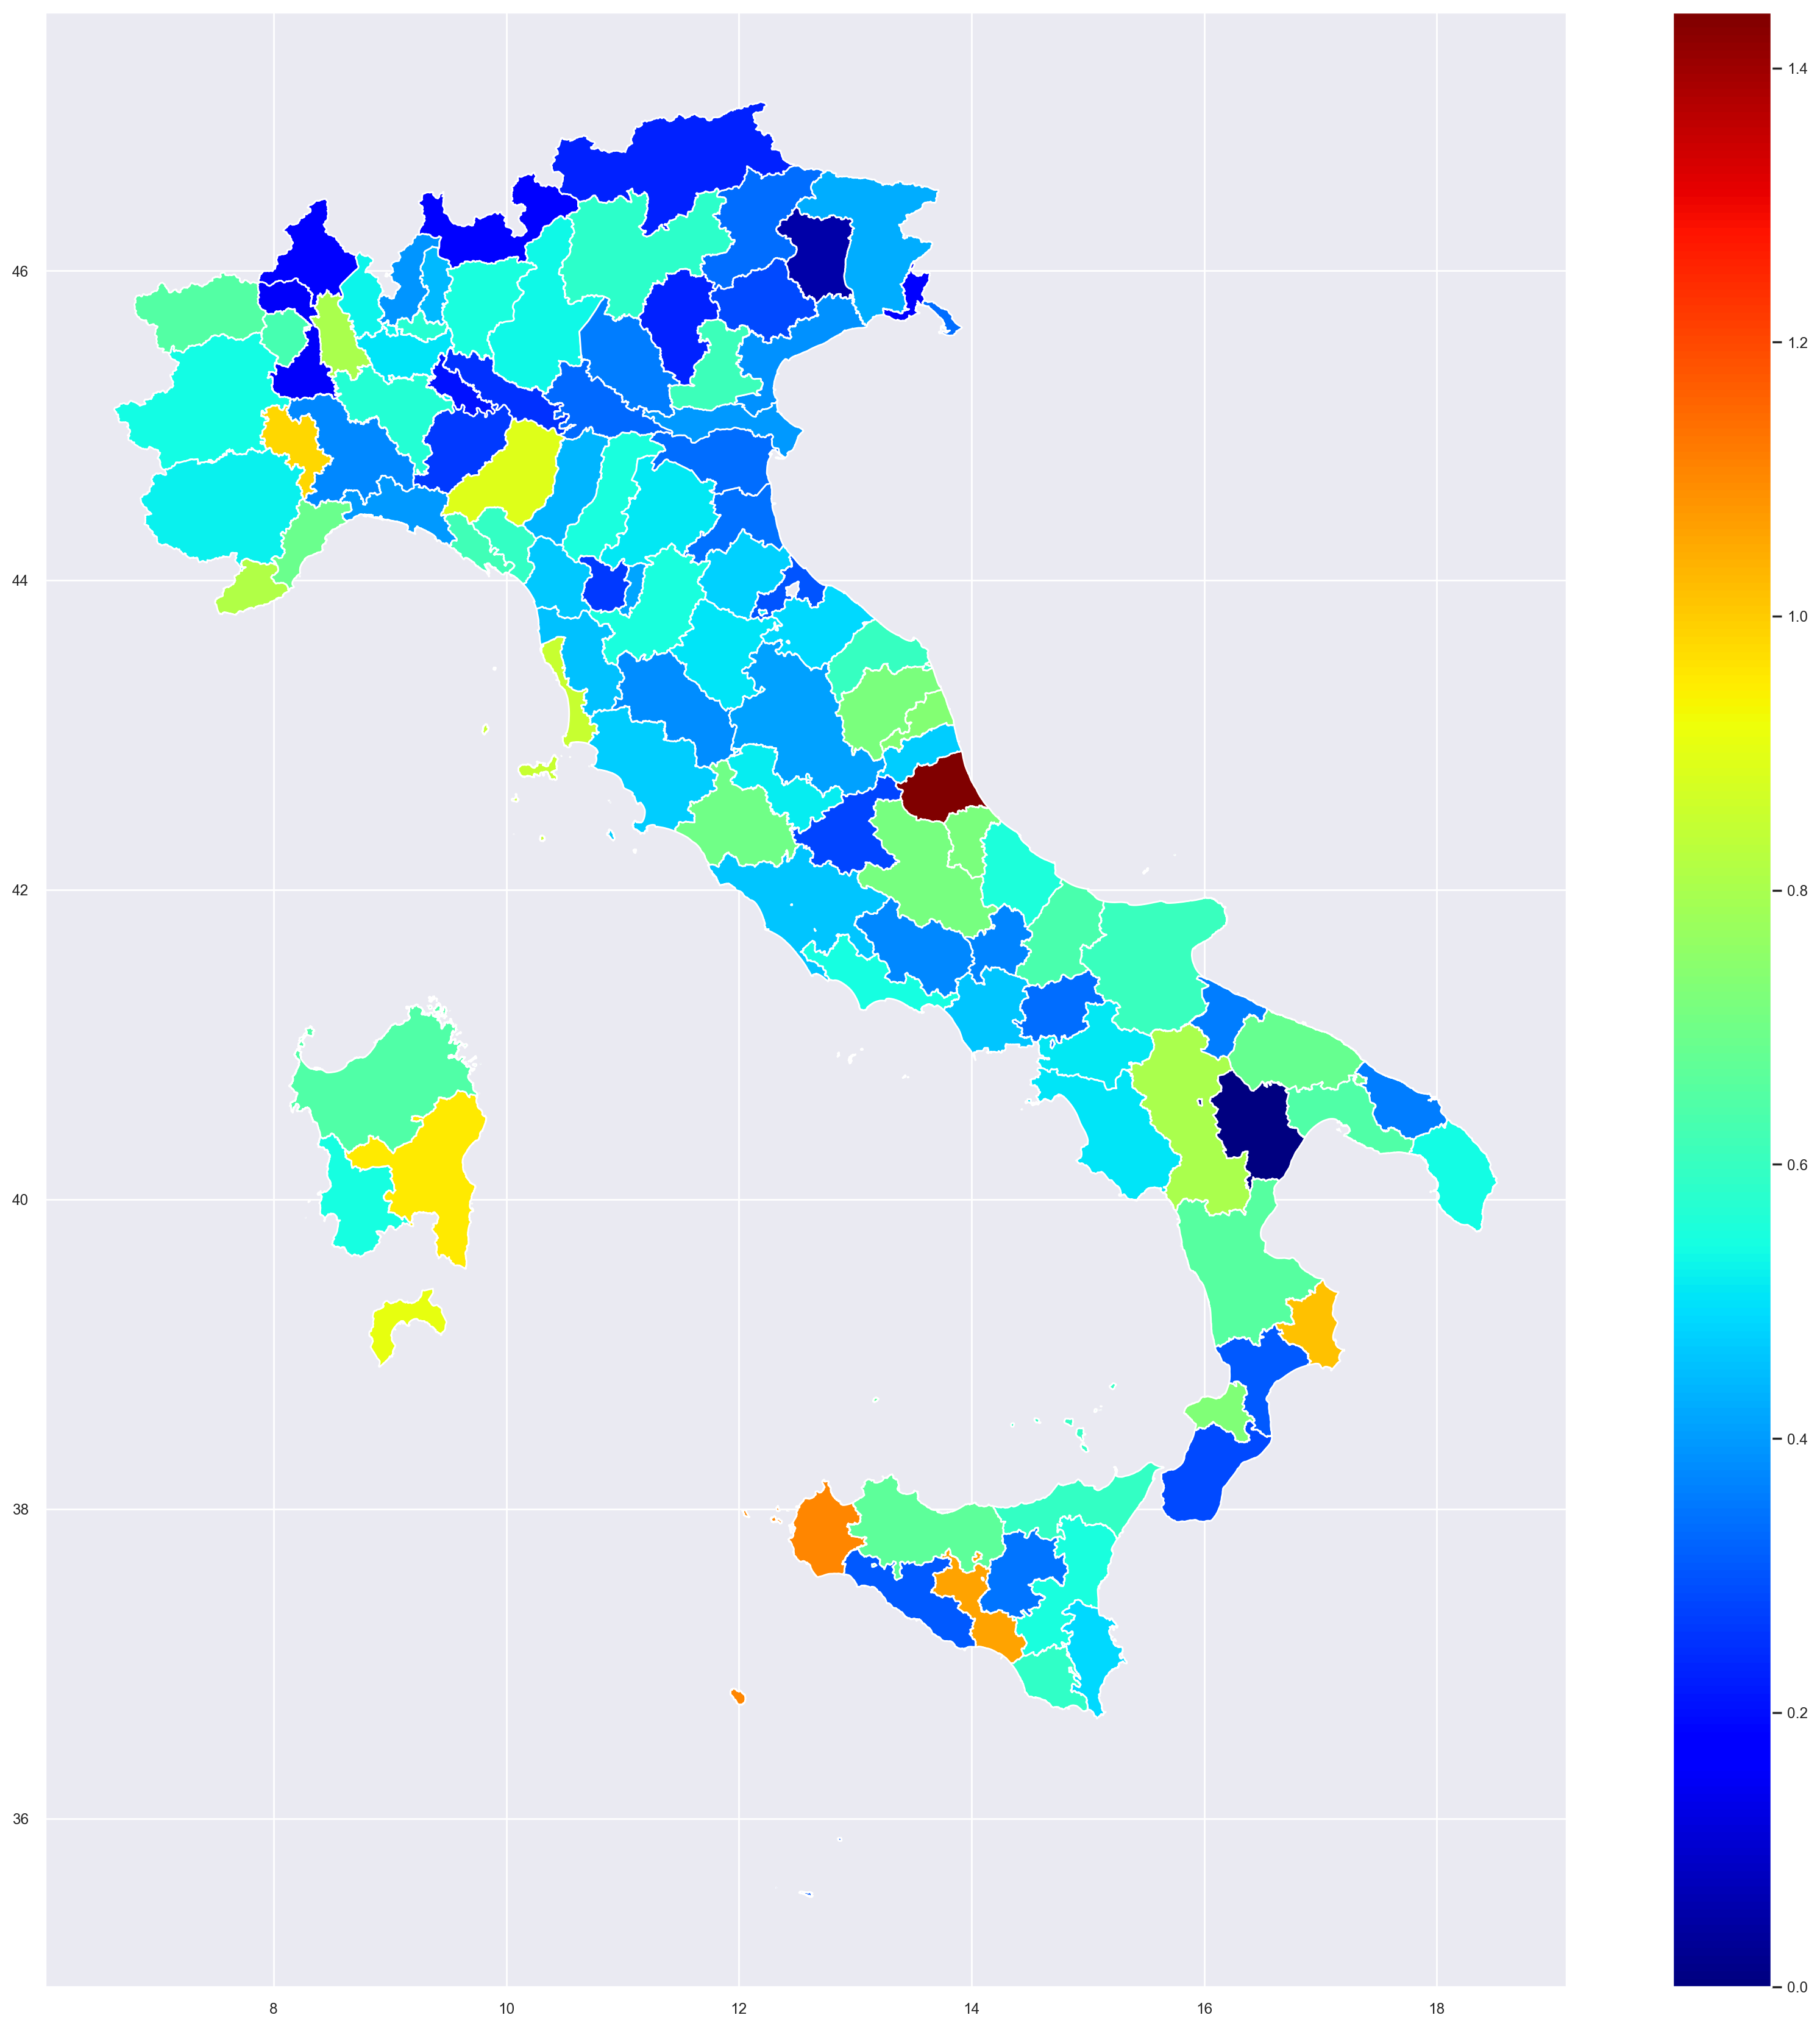

In [178]:


italy_p.plot(column='Yes', legend=True, cmap='jet', figsize = (20,20))
plt.show()